In [ ]:
!pip install rasterio tensorflow matplotlib opencv-python --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 47.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

image_dir = '/images'
mask_dir = '/masks'

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])
print(image_files)
print(mask_files)


['/images/Perungudi_Agri_RGB_2023.tif', '/images/Perungudi_Waste_RGB_2023.tif', '/images/Perungudi_Water_RGB_2023.tif']
['/masks/Perungudi_Agri_MASK_2024.tif', '/masks/Perungudi_Waste_MASK_2024.tif', '/masks/Perungudi_Water_MASK_2024.tif']


In [ ]:
def load_multiband_image(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)  # (bands, H, W)
        img = np.moveaxis(img, 0, -1)       # (H, W, bands)
        img /= 10000.                       # Sentinel-2 reflectance normalization
    return img

def load_mask(path):
    with rasterio.open(path) as src:
        msk = src.read(1).astype(np.uint8)
    return msk

images = [load_multiband_image(f) for f in image_files]
masks = [load_mask(f) for f in mask_files]
print('Number of images:', len(images), 'Number of masks:', len(masks))
print('Shape of first image:', images[0].shape, 'Shape of first mask:', masks[0].shape)

Number of images: 3 Number of masks: 3
Shape of first image: (129, 132, 3) Shape of first mask: (129, 132)


In [ ]:
from tensorflow.image import resize
import tensorflow as tf

num_classes = 3

# Define the target shape for masks to match the model's output spatial shape
# Based on the model summary, the output shape is (None, 128, 132, 3)
target_mask_shape = (128, 132) # Get height and width from model output shape

# Resize masks to the target mask shape *before* one-hot encoding
# Use 'nearest' interpolation to maintain discrete class values
resized_masks = [tf.image.resize(mask[..., tf.newaxis], target_mask_shape, method='nearest')[..., 0] for mask in masks]


# Explicitly map original mask values to 0-indexed classes and handle 255
processed_masks = []
for mask in resized_masks: # Use resized masks here
    processed_mask = np.zeros_like(mask, dtype=np.uint8)
    processed_mask[mask == 1] = 0  # Map original value 1 to class 0
    processed_mask[mask == 2] = 1  # Map original value 2 to class 1
    processed_mask[mask == 3] = 2  # Map original value 3 to class 2
    processed_mask[mask == 255] = 0 # Map original value 255 to class 0 (background/ignored)
    processed_masks.append(processed_mask)

# Add print statements to inspect the values after explicit mapping and resizing
print("Unique values and counts in the first processed mask after explicit mapping and resizing:")
unique_values, counts = np.unique(processed_masks[0], return_counts=True)
print(dict(zip(unique_values, counts)))


onehot_masks = [to_categorical(p_mask, num_classes) for p_mask in processed_masks] # convert each processed mask

Unique values and counts in the first processed mask after explicit mapping and resizing:
{np.uint8(0): np.int64(16402), np.uint8(2): np.int64(494)}


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, onehot_masks, test_size=0.33, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D
import numpy as np # Import numpy for max

def unet(input_shape=(128,132,3), num_classes=3): # Updated input shape
    inputs = Input(shape=input_shape)
    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)
    # Bridge
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    # Decoder
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    # Crop c2 to match the dimensions of u1
    crop_h2 = np.maximum(0, c2.shape[1] - u1.shape[1])
    crop_w2 = np.maximum(0, c2.shape[2] - u1.shape[2])
    c2_cropped = Cropping2D(cropping=((0, crop_h2), (0, crop_w2)))(c2)
    concat1 = concatenate([u1, c2_cropped])
    c3 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    # Crop c1 to match the dimensions of u2
    crop_h1 = np.maximum(0, c1.shape[1] - u2.shape[1])
    crop_w1 = np.maximum(0, c1.shape[2] - u2.shape[2])
    c1_cropped = Cropping2D(cropping=((0, crop_h1), (0, crop_w1)))(c1)
    concat2 = concatenate([u2, c1_cropped])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(concat2)
    outputs = Conv2D(num_classes, 1, activation='softmax')(c4)
    return Model(inputs, outputs)

model = unet(input_shape=(128,132,3), num_classes=num_classes) # Updated input shape
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 132,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 132,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 66,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 66,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 33,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 33,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 64, 66,    │     32,832 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d_6        │ (None, 64, 66,    │          0 │ conv2d_21[0][0]   │
│ (Cropping2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 64, 66,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ cropping2d_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 66,    │     73,792 │ concatenate_7[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 128, 132,  │      8,224 │ conv2d_23[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d_7        │ (None, 128, 132,  │          0 │ conv2d_20[0][0]   │
│ (Cropping2D)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 128, 132,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ cropping2d_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 132,  │     18,464 │ concatenate_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 132,  │         99 │ conv2d_24[0][0]   │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 226,659 (885.39 KB)

 Trainable params: 226,659 (885.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.image import resize
import tensorflow as tf
import numpy as np

# Define the target shape for images to match the height of the masks and model output
target_image_shape = (128, 132) # Match the height of the masks and model output

# Resize images to the target shape
resized_images = [resize(img, target_image_shape) for img in images]


# Split the resized images and the already resized and one-hot encoded masks
# y_train and y_val here will contain tensors from the onehot_masks list
X_train, X_val, y_train, y_val = train_test_split(resized_images, onehot_masks, test_size=0.33, random_state=42)


# Convert lists of resized tensors to NumPy arrays
# The tensors in X_train, X_val, y_train, and y_val should already have the correct shapes
# Remove .numpy() as elements are already numpy arrays after train_test_split
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_val_np = np.array(X_val)
y_val_np = np.array(y_val)

# Print shapes before training
print("Shape of X_train_np:", X_train_np.shape)
print("Shape of y_train_np:", y_train_np.shape)
print("Shape of X_val_np:", X_val_np.shape)
print("Shape of y_val_np:", y_val_np.shape)


# Set batch size to the size of the respective datasets to train and validate on a single batch
train_batch_size = len(X_train_np)
val_batch_size = len(X_val_np)


# Warm-up step: Run a small batch through the model to allow tf.function to trace and create variables
# Use a small subset of the training data for warm-up
_ = model.predict(X_train_np[:1], verbose=0)

# Temporarily disable tf.function for debugging
tf.config.run_functions_eagerly(True)

history = model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=150,
    batch_size=train_batch_size # Use the training dataset size as batch size
)

# Re-enable tf.function (optional, but good practice if you have subsequent tf.function calls)
tf.config.run_functions_eagerly(False)

Shape of X_train_np: (2, 128, 132, 3)
Shape of y_train_np: (2, 128, 132, 3)
Shape of X_val_np: (1, 128, 132, 3)
Shape of y_val_np: (1, 128, 132, 3)
Epoch 1/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8608 - loss: nan - val_accuracy: 0.9708 - val_loss: nan
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8608 - loss: nan - val_accuracy: 0.9708 - val_loss: nan
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8608 - loss: nan - val_accuracy: 0.9708 - val_loss: nan
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8608 - loss: nan - val_accuracy: 0.9708 - val_loss: nan
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8608 - loss: nan - val_accuracy: 0.9708 - val_loss: nan
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8608 - loss: nan - val_accuracy: 0.9708 - val_loss: nan
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8608 - loss: nan - val_accuracy: 0.9708 - val_loss: nan
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


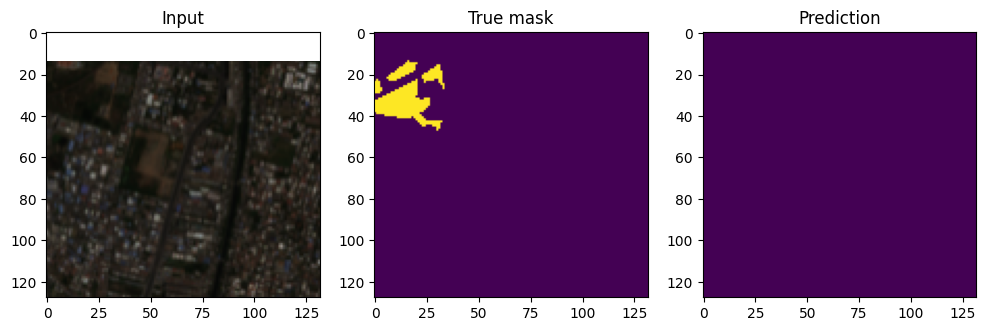

In [ ]:
def show_sample(idx):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title('Input')
    plt.imshow(X_val[idx][:,:,0:3])
    plt.subplot(1,3,2)
    plt.title('True mask')
    plt.imshow(np.argmax(y_val[idx], axis=-1), cmap='viridis')
    plt.subplot(1,3,3)
    pred = model.predict(X_val[idx][np.newaxis, ...])
    plt.title('Prediction')
    plt.imshow(np.argmax(pred[0], axis=-1), cmap='viridis')
    plt.show()

show_sample(0)


Image files: ['/images/Perungudi_Agri_RGB_2023.tif', '/images/Perungudi_Waste_RGB_2023.tif', '/images/Perungudi_Water_RGB_2023.tif']
Mask files: ['/masks/Perungudi_Agri_MASK_2024.tif', '/masks/Perungudi_Waste_MASK_2024.tif', '/masks/Perungudi_Water_MASK_2024.tif']
Number of images: 3 Number of masks: 3
Shape of first image: (129, 132, 3) Shape of first mask: (129, 132)
Unique values in masks before processing:
Mask 0: [0 3]
Mask 1: [0 1 2 3]
Mask 2: [0 1 2 3]
Class distribution after processing:
Mask 0: {np.uint8(0): np.int64(15914), np.uint8(2): np.int64(470)}
Mask 1: {np.uint8(0): np.int64(13363), np.uint8(1): np.int64(2682), np.uint8(2): np.int64(339)}
Mask 2: {np.uint8(0): np.int64(14840), np.uint8(1): np.int64(1211), np.uint8(2): np.int64(333)}
Final dataset shapes:
X shape: (3, 128, 128, 3)
y shape: (3, 128, 128, 3)
Training shapes:
X_train: (2, 128, 128, 3) y_train: (2, 128, 128, 3)
X_val: (1, 128, 128, 3) y_val: (1, 128, 128, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      8,224 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │     18,464 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_8[0][0]  

 Total params: 466,595 (1.78 MB)

 Trainable params: 466,595 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.2921 - loss: 1.1007 - val_accuracy: 0.5151 - val_loss: 1.0949 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4776 - loss: 1.0949 - val_accuracy: 0.7238 - val_loss: 1.0889 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6599 - loss: 1.0891 - val_accuracy: 0.8611 - val_loss: 1.0829 - learning_rate: 1.0000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7687 - loss: 1.0833 - val_accuracy: 0.9238 - val_loss: 1.0768 - learning_rate: 1.0000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8180 - loss: 1.0776 - val_accuracy: 0.9457 - val_loss: 1.0708 - learning_rate: 1.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8374 - loss: 1.0718 - val_accuracy: 0.9546 - val_loss: 1.0647 - learning_rate: 1.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy:

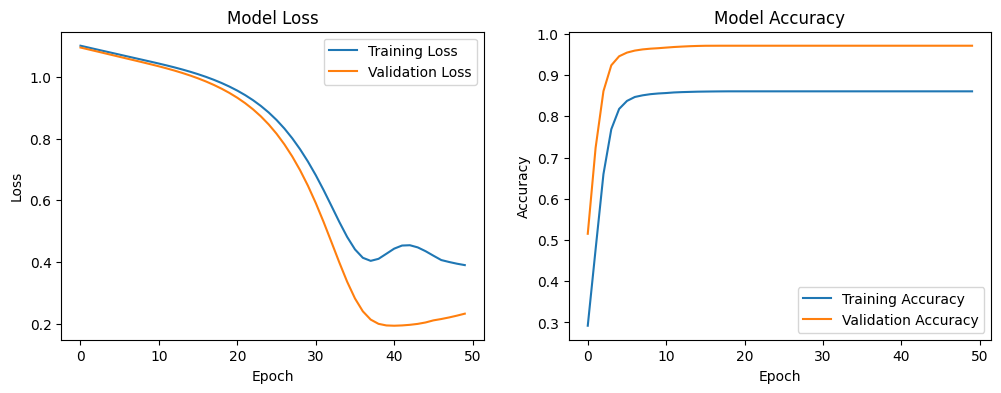

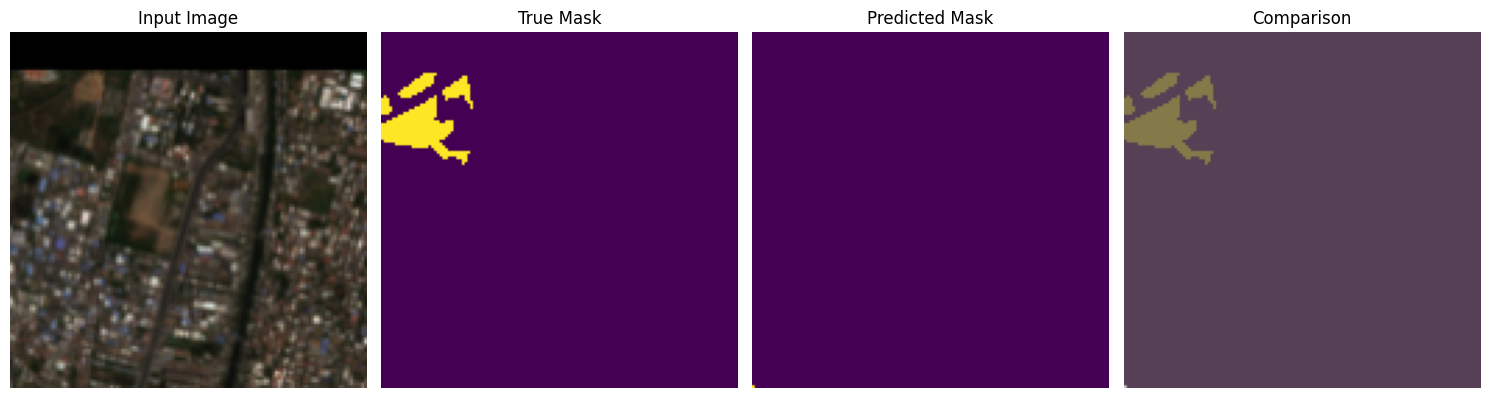

In [ ]:


# Step 3: Import libraries
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam

# Step 4: Set paths and list files
image_dir = '/images'  # Update this path
mask_dir = '/masks'    # Update this path

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])
print("Image files:", image_files)
print("Mask files:", mask_files)

# Step 5: Load data with proper error handling
def load_multiband_image(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)  # (bands, H, W)
        img = np.moveaxis(img, 0, -1)       # (H, W, bands)
        # Check for and handle NaN/infinite values
        img = np.nan_to_num(img)
        # Normalize to [0, 1] range instead of fixed 10000 division
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return img

def load_mask(path):
    with rasterio.open(path) as src:
        msk = src.read(1).astype(np.uint8)
    return msk

images = [load_multiband_image(f) for f in image_files]
masks = [load_mask(f) for f in mask_files]

print('Number of images:', len(images), 'Number of masks:', len(masks))
print("Shape of first image:", images[0].shape, 'Shape of first mask:', masks[0].shape)

# Step 6: Resize images and masks to consistent dimensions
target_size = (128, 128)  # Use square dimensions for simplicity

# Resize images
resized_images = [tf.image.resize(img, target_size, method='bilinear').numpy() for img in images]

# Resize masks with nearest neighbor to preserve categorical values
resized_masks = [tf.image.resize(mask[..., np.newaxis], target_size, method='nearest').numpy() for mask in masks]
resized_masks = [mask[..., 0] for mask in resized_masks]  # Remove channel dimension

# Step 7: Process masks and handle class mapping
print("Unique values in masks before processing:")
for i, mask in enumerate(resized_masks):
    unique_vals = np.unique(mask)
    print(f"Mask {i}: {unique_vals}")

# Map mask values to 0-indexed classes
processed_masks = []
for mask in resized_masks:
    processed_mask = np.zeros_like(mask, dtype=np.uint8)
    # Adjust these mappings based on your actual mask values
    processed_mask[mask == 1] = 0  # Class 0
    processed_mask[mask == 2] = 1  # Class 1
    processed_mask[mask == 3] = 2  # Class 2
    processed_mask[mask == 255] = 0  # Ignore 255 values
    processed_masks.append(processed_mask)

# Verify class distribution
print("Class distribution after processing:")
for i, mask in enumerate(processed_masks):
    unique_vals, counts = np.unique(mask, return_counts=True)
    print(f"Mask {i}: {dict(zip(unique_vals, counts))}")

# Step 8: One-hot encode masks
num_classes = 3
onehot_masks = [to_categorical(mask, num_classes) for mask in processed_masks]

# Step 9: Convert to numpy arrays and split
X = np.array(resized_images)
y = np.array(onehot_masks)

print("Final dataset shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print("Training shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)

# Step 10: Define a simpler, more robust UNet model
def simple_unet(input_shape=(128, 128, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bridge
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = Conv2D(128, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u2)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c4)

    return Model(inputs, outputs)

# Step 11: Create and compile model with proper settings
model = simple_unet(input_shape=X_train.shape[1:], num_classes=num_classes)

# Use a lower learning rate and different loss function to prevent NaN
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Step 12: Add callbacks for better training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

# Step 13: Train the model
print("Starting training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=2,
    callbacks=callbacks,
    verbose=1
)

# Step 14: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Step 15: Visualize predictions
def show_sample(idx):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.title('Input Image')
    plt.imshow(X_val[idx])
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('True Mask')
    true_mask = np.argmax(y_val[idx], axis=-1)
    plt.imshow(true_mask, cmap='viridis')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('Predicted Mask')
    pred = model.predict(X_val[idx][np.newaxis, ...], verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1)
    plt.imshow(pred_mask, cmap='viridis')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Comparison')
    plt.imshow(true_mask, cmap='viridis', alpha=0.5)
    plt.imshow(pred_mask, cmap='hot', alpha=0.5)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show a few samples
for i in range(min(3, len(X_val))):
    show_sample(i)

In [ ]:
# Step 3: Import libraries
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Step 4: Set paths and list files
image_dir = '/images'  # Update this path
mask_dir = '/masks'    # Update this path

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])
print("Image files:", image_files)
print("Mask files:", mask_files)

# Step 5: Load data with proper error handling
def load_multiband_image(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)  # (bands, H, W)
        img = np.moveaxis(img, 0, -1)       # (H, W, bands)
        # Check for and handle NaN/infinite values
        img = np.nan_to_num(img)
        # Normalize to [0, 1] range instead of fixed 10000 division
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return img

def load_mask(path):
    with rasterio.open(path) as src:
        msk = src.read(1).astype(np.uint8)
    return msk

images = [load_multiband_image(f) for f in image_files]
masks = [load_mask(f) for f in mask_files]

print('Number of images:', len(images), 'Number of masks:', len(masks))
print("Shape of first image:", images[0].shape, 'Shape of first mask:', masks[0].shape)

# Step 6: Resize images and masks to consistent dimensions
target_size = (128, 128)  # Use square dimensions for simplicity

# Resize images
resized_images = [tf.image.resize(img, target_size, method='bilinear').numpy() for img in images]

# Resize masks with nearest neighbor to preserve categorical values
resized_masks = [tf.image.resize(mask[..., np.newaxis], target_size, method='nearest').numpy() for mask in masks]
resized_masks = [mask[..., 0] for mask in resized_masks]  # Remove channel dimension

# Step 7: Process masks and handle class mapping
print("Unique values in masks before processing:")
for i, mask in enumerate(resized_masks):
    unique_vals = np.unique(mask)
    print(f"Mask {i}: {unique_vals}")

# Map mask values to 0-indexed classes
processed_masks = []
for mask in resized_masks:
    processed_mask = np.zeros_like(mask, dtype=np.uint8)
    # Adjust these mappings based on your actual mask values
    processed_mask[mask == 1] = 0  # Class 0
    processed_mask[mask == 2] = 1  # Class 1
    processed_mask[mask == 3] = 2  # Class 2
    processed_mask[mask == 255] = 0  # Ignore 255 values
    processed_masks.append(processed_mask)

# Verify class distribution
print("Class distribution after processing:")
for i, mask in enumerate(processed_masks):
    unique_vals, counts = np.unique(mask, return_counts=True)
    print(f"Mask {i}: {dict(zip(unique_vals, counts))}")


# Step 8: Convert to numpy arrays and split (using processed_masks for masks)
X = np.array(resized_images)
y_processed = np.array(processed_masks) # Use processed masks here

print("Final dataset shapes:")
print("X shape:", X.shape)
print("y_processed shape:", y_processed.shape)

X_train, X_val, y_train_processed, y_val_processed = train_test_split(X, y_processed, test_size=0.33, random_state=42)

print("Training shapes (processed masks):")
print("X_train:", X_train.shape, "y_train_processed:", y_train_processed.shape)
print("X_val:", X_val.shape, "y_val_processed:", y_val_processed.shape)

# Step 9: Handle Class Imbalance with Class Weights (using flattened processed masks)
all_masks_flat = y_processed.flatten()
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(all_masks_flat),
                                   y=all_masks_flat)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights for imbalance:", class_weight_dict)

# Step 10: Enhanced Data Augmentation (apply to processed masks)
def manual_augmentation(images, masks, augmentation_factor=2):
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(images, masks):
        # Original
        augmented_images.append(img)
        augmented_masks.append(mask)

        # Augmentations
        for _ in range(augmentation_factor):
            img_aug = img
            mask_aug = mask

            # Random flip
            if np.random.random() > 0.5:
                img_aug = np.fliplr(img_aug)
                mask_aug = np.fliplr(mask_aug)

            # Random rotation
            angle = np.random.choice([0, 1, 2, 3])  # 0, 90, 180, 270 degrees
            img_aug = np.rot90(img_aug, angle)
            mask_aug = np.rot90(mask_aug, angle)

            augmented_images.append(img_aug)
            augmented_masks.append(mask_aug)

    return np.array(augmented_images), np.array(augmented_masks)

# Apply augmentation to images and processed masks
print("Applying data augmentation...")
X_train_aug, y_train_processed_aug = manual_augmentation(X_train, y_train_processed)
print(f"Training data after augmentation: {X_train_aug.shape}, {y_train_processed_aug.shape}")

# Step 11: One-hot encode augmented processed masks
num_classes = len(np.unique(y_processed)) # Use number of unique classes from processed masks
y_train_aug = to_categorical(y_train_processed_aug, num_classes=num_classes)
y_val = to_categorical(y_val_processed, num_classes=num_classes) # One-hot encode validation masks

print("Augmented and one-hot encoded shapes:")
print("X_train_aug:", X_train_aug.shape, "y_train_aug:", y_train_aug.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)


# Step 12: Define a simpler, more robust UNet model
def improved_unet(input_shape=(128, 128, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Encoder with batch normalization and dropout
    # Block 1
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    # Block 2
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    # Block 3
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.2)(p3)

    # Bridge
    b = Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = Conv2D(512, 3, activation='relu', padding='same')(b)
    b = BatchNormalization()(b)
    b = Dropout(0.3)(b)

    # Decoder
    # Block 4
    u1 = Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c3])
    u1 = Dropout(0.2)(u1)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    # Block 5
    u2 = Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c2])
    u2 = Dropout(0.1)(u2)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(128, 3, activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Block 6
    u3 = Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u3 = concatenate([u3, c1])
    u3 = Dropout(0.1)(u3)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(u3)
    c6 = Conv2D(64, 3, activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c6)

    return Model(inputs, outputs)

# Step 13: Create and compile improved model
# Determine input shape from augmented images
input_shape = X_train_aug.shape[1:]
model = improved_unet(input_shape=input_shape, num_classes=num_classes)

# Use a lower learning rate and different loss function to prevent NaN
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # You can also try 'focal_loss'
              metrics=['accuracy',
                      tf.keras.metrics.MeanIoU(num_classes=num_classes)])

model.summary()

# Step 14: Enhanced Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss'),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Step 15: Train the improved model
print("Starting training with improved setup...")
history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=4, # Use a small batch size suitable for the dataset size
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weight_dict  # Use class weights for imbalance
)

# Step 16: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Step 17: Visualize predictions
def show_sample(idx):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.title('Input Image')
    # Assuming RGB images for visualization
    if X_val[idx].shape[-1] >= 3:
        plt.imshow(X_val[idx][:, :, :3])
    else:
        plt.imshow(X_val[idx][:, :, 0], cmap='gray') # Show as grayscale if less than 3 channels
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('True Mask')
    true_mask = np.argmax(y_val[idx], axis=-1)
    plt.imshow(true_mask, cmap='viridis')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title('Predicted Mask')
    pred = model.predict(X_val[idx][np.newaxis, ...], verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1)
    plt.imshow(pred_mask, cmap='viridis')
    plt.axis('off')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title('Comparison')
    plt.imshow(true_mask, cmap='viridis', alpha=0.5)
    plt.imshow(pred_mask, cmap='hot', alpha=0.5)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n=== SAMPLE {idx} ANALYSIS ===")
    # Flatten masks for classification report and confusion matrix
    true_mask_flat = true_mask.flatten()
    pred_mask_flat = pred_mask.flatten()

    # Ensure all classes are present in target_names for classification report
    target_names = [f'Class_{i}' for i in np.unique(np.concatenate((true_mask_flat, pred_mask_flat)))]

    print("Confusion Matrix:")
    print(confusion_matrix(true_mask_flat, pred_mask_flat))
    print("\nClassification Report:")
    print(classification_report(true_mask_flat, pred_mask_flat,
                              target_names=target_names, zero_division=0))


# Analyze multiple samples
# Ensure there are samples in the validation set to show
if len(X_val) > 0:
    for i in range(min(3, len(X_val))):
        detailed_analysis(i)
else:
    print("No validation data available to show sample predictions.")

Image files: ['/images/Perungudi_Agri_RGB_2023.tif', '/images/Perungudi_Waste_RGB_2023.tif', '/images/Perungudi_Water_RGB_2023.tif']
Mask files: ['/masks/Perungudi_Agri_MASK_2024.tif', '/masks/Perungudi_Waste_MASK_2024.tif', '/masks/Perungudi_Water_MASK_2024.tif']
Number of images: 3 Number of masks: 3
Shape of first image: (129, 132, 3) Shape of first mask: (129, 132)
Unique values in masks before processing:
Mask 0: [0 3]
Mask 1: [0 1 2 3]
Mask 2: [0 1 2 3]
Class distribution after processing:
Mask 0: {np.uint8(0): np.int64(15914), np.uint8(2): np.int64(470)}
Mask 1: {np.uint8(0): np.int64(13363), np.uint8(1): np.int64(2682), np.uint8(2): np.int64(339)}
Mask 2: {np.uint8(0): np.int64(14840), np.uint8(1): np.int64(1211), np.uint8(2): np.int64(333)}
Final dataset shapes:
X shape: (3, 128, 128, 3)
y_processed shape: (3, 128, 128)
Training shapes (processed masks):
X_train: (2, 128, 128, 3) y_train_processed: (2, 128, 128)
X_val: (1, 128, 128, 3) y_val_processed: (1, 128, 128)
Class weig

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_26[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_7[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_28[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │    295,168 │ dropout_8[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_30[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ dropout_9[0][0] 

 Total params: 7,703,107 (29.39 MB)

 Trainable params: 7,700,291 (29.37 MB)

 Non-trainable params: 2,816 (11.00 KB)

Starting training with improved setup...


TypeError: only length-1 arrays can be converted to Python scalars

TensorFlow Version: 2.19.0
Loading your data...
Loaded 3 images and 3 masks
Final dataset shapes:
X_train: (2, 128, 128, 3), y_train: (2, 128, 128, 3)
X_val: (1, 128, 128, 3), y_val: (1, 128, 128, 3)
All models built successfully!

Starting training for Improved_UNet...

TRAINING: Improved_UNet
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3508 - loss: 1.1598

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.3508 - loss: 1.1598 - val_accuracy: 0.8391 - val_loss: 1.0858 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3734 - loss: 1.1193 - val_accuracy: 0.8116 - val_loss: 1.0871 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.3990 - loss: 1.0827 - val_accuracy: 0.7493 - val_loss: 1.0887 - learning_rate: 1.0000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4285 - loss: 1.0503 - val_accuracy: 0.6432 - val_loss: 1.0908 - learning_rate: 1.0000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.4571 - loss: 1.0219 - val_accuracy: 0.5214 - val_loss: 1.0932 - learning_rate: 1.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4871 - loss: 0.9970 - val_accuracy: 0.4025 - val_loss: 1.0957 - learning_rate: 1.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5130 - loss: 0.9750 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.1130 - loss: 1.8681 - val_accuracy: 0.0242 - val_loss: 1.1089 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1273 - loss: 1.8174

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.1273 - loss: 1.8174 - val_accuracy: 0.0190 - val_loss: 1.1087 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1396 - loss: 1.7715

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.1396 - loss: 1.7715 - val_accuracy: 0.0142 - val_loss: 1.1084 - learning_rate: 1.0000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1523 - loss: 1.7298

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.1523 - loss: 1.7298 - val_accuracy: 0.0097 - val_loss: 1.1080 - learning_rate: 1.0000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1638 - loss: 1.6915

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1638 - loss: 1.6915 - val_accuracy: 0.0098 - val_loss: 1.1076 - learning_rate: 1.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1749 - loss: 1.6561

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.1749 - loss: 1.6561 - val_accuracy: 0.0107 - val_loss: 1.1070 - learning_rate: 1.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1854 - loss: 1.6234

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.1854 - loss: 1.6234 - val_accuracy: 0.0173 - val_loss: 1.1062 - learning_rate: 1.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1977 - loss: 1.5927

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.1977 - loss: 1.5927 - val_accuracy: 0.0284 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2099 - loss: 1.5637

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.2099 - loss: 1.5637 - val_accuracy: 0.0475 - val_loss: 1.1044 - learning_rate: 1.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2228 - loss: 1.5363

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2228 - loss: 1.5363 - val_accuracy: 0.0706 - val_loss: 1.1034 - learning_rate: 1.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2354 - loss: 1.5104

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.2354 - loss: 1.5104 - val_accuracy: 0.0962 - val_loss: 1.1025 - learning_rate: 1.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2489 - loss: 1.4858

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.2489 - loss: 1.4858 - val_accuracy: 0.1196 - val_loss: 1.1018 - learning_rate: 1.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2645 - loss: 1.4621

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2645 - loss: 1.4621 - val_accuracy: 0.1369 - val_loss: 1.1011 - learning_rate: 1.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2802 - loss: 1.4393

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.2802 - loss: 1.4393 - val_accuracy: 0.1470 - val_loss: 1.1006 - learning_rate: 1.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2965 - loss: 1.4171

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.2965 - loss: 1.4171 - val_accuracy: 0.1545 - val_loss: 1.1003 - learning_rate: 1.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3123 - loss: 1.3954

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.3123 - loss: 1.3954 - val_accuracy: 0.1587 - val_loss: 1.1001 - learning_rate: 1.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3311 - loss: 1.3743

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.3311 - loss: 1.3743 - val_accuracy: 0.1572 - val_loss: 1.1001 - learning_rate: 1.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3506 - loss: 1.3538 - val_accuracy: 0.1515 - val_loss: 1.1003 - learning_rate: 1.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3681 - loss: 1.3337 - val_accuracy: 0.1448 - val_loss: 1.1007 - learning_rate: 1.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3874 - loss: 1.3141 - val_accuracy: 0.1378 - val_loss: 1.1013 - learning_rate: 1.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4076 - loss: 1.2948 - val_accuracy: 0.1296 - val_loss: 1.1021 - learning_rate: 1.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4262 - loss: 1.2757 - val_accuracy: 0.1195 - val_loss: 1.1032 - learning_rate: 1.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4462 - loss: 1.2568 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.1759 - loss: 1.8098 - val_accuracy: 0.1442 - val_loss: 1.1037 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1883 - loss: 1.7228

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.1883 - loss: 1.7228 - val_accuracy: 0.1472 - val_loss: 1.1016 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2052 - loss: 1.6409

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2052 - loss: 1.6409 - val_accuracy: 0.1569 - val_loss: 1.0994 - learning_rate: 1.0000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2257 - loss: 1.5646

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.2257 - loss: 1.5646 - val_accuracy: 0.1722 - val_loss: 1.0974 - learning_rate: 1.0000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2491 - loss: 1.4942

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.2491 - loss: 1.4942 - val_accuracy: 0.1870 - val_loss: 1.0961 - learning_rate: 1.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2759 - loss: 1.4295

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.2759 - loss: 1.4295 - val_accuracy: 0.1987 - val_loss: 1.0954 - learning_rate: 1.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3026 - loss: 1.3695

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3026 - loss: 1.3695 - val_accuracy: 0.2085 - val_loss: 1.0952 - learning_rate: 1.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3288 - loss: 1.3136 - val_accuracy: 0.2121 - val_loss: 1.0953 - learning_rate: 1.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3552 - loss: 1.2610 - val_accuracy: 0.2165 - val_loss: 1.0954 - learning_rate: 1.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3808 - loss: 1.2111 - val_accuracy: 0.2211 - val_loss: 1.0954 - learning_rate: 1.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4093 - loss: 1.1636

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4093 - loss: 1.1636 - val_accuracy: 0.2272 - val_loss: 1.0952 - learning_rate: 1.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4367 - loss: 1.1182

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.4367 - loss: 1.1182 - val_accuracy: 0.2333 - val_loss: 1.0947 - learning_rate: 1.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4650 - loss: 1.0749

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4650 - loss: 1.0749 - val_accuracy: 0.2434 - val_loss: 1.0939 - learning_rate: 1.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4947 - loss: 1.0335

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.4947 - loss: 1.0335 - val_accuracy: 0.2596 - val_loss: 1.0928 - learning_rate: 1.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5237 - loss: 0.9940

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5237 - loss: 0.9940 - val_accuracy: 0.2742 - val_loss: 1.0913 - learning_rate: 1.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5495 - loss: 0.9563

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5495 - loss: 0.9563 - val_accuracy: 0.2894 - val_loss: 1.0896 - learning_rate: 1.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5751 - loss: 0.9204

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5751 - loss: 0.9204 - val_accuracy: 0.3051 - val_loss: 1.0876 - learning_rate: 1.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5992 - loss: 0.8860

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.5992 - loss: 0.8860 - val_accuracy: 0.3227 - val_loss: 1.0853 - learning_rate: 1.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6231 - loss: 0.8530

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6231 - loss: 0.8530 - val_accuracy: 0.3410 - val_loss: 1.0827 - learning_rate: 1.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6470 - loss: 0.8212

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.6470 - loss: 0.8212 - val_accuracy: 0.3624 - val_loss: 1.0798 - learning_rate: 1.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6698 - loss: 0.7906

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6698 - loss: 0.7906 - val_accuracy: 0.3897 - val_loss: 1.0765 - learning_rate: 1.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6925 - loss: 0.7611

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6925 - loss: 0.7611 - val_accuracy: 0.4160 - val_loss: 1.0730 - learning_rate: 1.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7136 - loss: 0.7328

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7136 - loss: 0.7328 - val_accuracy: 0.4470 - val_loss: 1.0690 - learning_rate: 1.0000e-04
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7344 - loss: 0.7056

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.7344 - loss: 0.7056 - val_accuracy: 0.4731 - val_loss: 1.0648 - learning_rate: 1.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7541 - loss: 0.6796

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - accuracy: 0.7541 - loss: 0.6796 - val_accuracy: 0.5071 - val_loss: 1.0602 - learning_rate: 1.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7728 - loss: 0.6547

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7728 - loss: 0.6547 - val_accuracy: 0.5330 - val_loss: 1.0552 - learning_rate: 1.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7903 - loss: 0.6309

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - accuracy: 0.7903 - loss: 0.6309 - val_accuracy: 0.5620 - val_loss: 1.0499 - learning_rate: 1.0000e-04
Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8049 - loss: 0.6082

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8049 - loss: 0.6082 - val_accuracy: 0.5895 - val_loss: 1.0442 - learning_rate: 1.0000e-04
Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8199 - loss: 0.5866

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step - accuracy: 0.8199 - loss: 0.5866 - val_accuracy: 0.6205 - val_loss: 1.0382 - learning_rate: 1.0000e-04
Epoch 30/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8333 - loss: 0.5660

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8333 - loss: 0.5660 - val_accuracy: 0.6504 - val_loss: 1.0317 - learning_rate: 1.0000e-04
Epoch 31/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8454 - loss: 0.5463

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8454 - loss: 0.5463 - val_accuracy: 0.6821 - val_loss: 1.0250 - learning_rate: 1.0000e-04
Epoch 32/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8553 - loss: 0.5275

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8553 - loss: 0.5275 - val_accuracy: 0.7194 - val_loss: 1.0179 - learning_rate: 1.0000e-04
Epoch 33/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8640 - loss: 0.5096

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8640 - loss: 0.5096 - val_accuracy: 0.7557 - val_loss: 1.0104 - learning_rate: 1.0000e-04
Epoch 34/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8716 - loss: 0.4926

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8716 - loss: 0.4926 - val_accuracy: 0.7911 - val_loss: 1.0027 - learning_rate: 1.0000e-04
Epoch 35/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8802 - loss: 0.4763

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8802 - loss: 0.4763 - val_accuracy: 0.8258 - val_loss: 0.9946 - learning_rate: 1.0000e-04
Epoch 36/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8872 - loss: 0.4609

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8872 - loss: 0.4609 - val_accuracy: 0.8581 - val_loss: 0.9862 - learning_rate: 1.0000e-04
Epoch 37/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8933 - loss: 0.4462

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.8933 - loss: 0.4462 - val_accuracy: 0.8852 - val_loss: 0.9776 - learning_rate: 1.0000e-04
Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8987 - loss: 0.4322

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8987 - loss: 0.4322 - val_accuracy: 0.9071 - val_loss: 0.9686 - learning_rate: 1.0000e-04
Epoch 39/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9027 - loss: 0.4189

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9027 - loss: 0.4189 - val_accuracy: 0.9255 - val_loss: 0.9594 - learning_rate: 1.0000e-04
Epoch 40/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9071 - loss: 0.4063

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9071 - loss: 0.4063 - val_accuracy: 0.9403 - val_loss: 0.9500 - learning_rate: 1.0000e-04
Epoch 41/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9109 - loss: 0.3943

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.9109 - loss: 0.3943 - val_accuracy: 0.9517 - val_loss: 0.9403 - learning_rate: 1.0000e-04
Epoch 42/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9146 - loss: 0.3828

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9146 - loss: 0.3828 - val_accuracy: 0.9583 - val_loss: 0.9304 - learning_rate: 1.0000e-04
Epoch 43/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9176 - loss: 0.3719

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9176 - loss: 0.3719 - val_accuracy: 0.9642 - val_loss: 0.9203 - learning_rate: 1.0000e-04
Epoch 44/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9199 - loss: 0.3615

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9199 - loss: 0.3615 - val_accuracy: 0.9670 - val_loss: 0.9101 - learning_rate: 1.0000e-04
Epoch 45/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9222 - loss: 0.3515

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9222 - loss: 0.3515 - val_accuracy: 0.9687 - val_loss: 0.8996 - learning_rate: 1.0000e-04
Epoch 46/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9250 - loss: 0.3421

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9250 - loss: 0.3421 - val_accuracy: 0.9699 - val_loss: 0.8890 - learning_rate: 1.0000e-04
Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9265 - loss: 0.3331

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9265 - loss: 0.3331 - val_accuracy: 0.9703 - val_loss: 0.8783 - learning_rate: 1.0000e-04
Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9286 - loss: 0.3245

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9286 - loss: 0.3245 - val_accuracy: 0.9705 - val_loss: 0.8674 - learning_rate: 1.0000e-04
Epoch 49/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9302 - loss: 0.3163

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9302 - loss: 0.3163 - val_accuracy: 0.9706 - val_loss: 0.8565 - learning_rate: 1.0000e-04
Epoch 50/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9321 - loss: 0.3084

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9321 - loss: 0.3084 - val_accuracy: 0.9709 - val_loss: 0.8454 - learning_rate: 1.0000e-04
✅ ResUNet training completed successfully!

Starting training for IRUNet...

TRAINING: IRUNet
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.0788 - loss: 1.9603

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.0788 - loss: 1.9603 - val_accuracy: 0.0309 - val_loss: 1.1284 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1056 - loss: 1.8624

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.1056 - loss: 1.8624 - val_accuracy: 0.0299 - val_loss: 1.1215 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1299 - loss: 1.7824

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.1299 - loss: 1.7824 - val_accuracy: 0.0360 - val_loss: 1.1146 - learning_rate: 1.0000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1508 - loss: 1.7137

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.1508 - loss: 1.7137 - val_accuracy: 0.0925 - val_loss: 1.1081 - learning_rate: 1.0000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1755 - loss: 1.6529

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.1755 - loss: 1.6529 - val_accuracy: 0.2352 - val_loss: 1.1021 - learning_rate: 1.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2020 - loss: 1.5981

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.2020 - loss: 1.5981 - val_accuracy: 0.4140 - val_loss: 1.0970 - learning_rate: 1.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.2318 - loss: 1.5488

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step - accuracy: 0.2318 - loss: 1.5488 - val_accuracy: 0.5395 - val_loss: 1.0928 - learning_rate: 1.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2603 - loss: 1.5040

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.2603 - loss: 1.5040 - val_accuracy: 0.6090 - val_loss: 1.0897 - learning_rate: 1.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2885 - loss: 1.4631

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.2885 - loss: 1.4631 - val_accuracy: 0.6448 - val_loss: 1.0875 - learning_rate: 1.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3145 - loss: 1.4251

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3145 - loss: 1.4251 - val_accuracy: 0.6615 - val_loss: 1.0864 - learning_rate: 1.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3404 - loss: 1.3889

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3404 - loss: 1.3889 - val_accuracy: 0.6588 - val_loss: 1.0863 - learning_rate: 1.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3676 - loss: 1.3541 - val_accuracy: 0.6384 - val_loss: 1.0870 - learning_rate: 1.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3939 - loss: 1.3204 - val_accuracy: 0.6047 - val_loss: 1.0886 - learning_rate: 1.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4204 - loss: 1.2877 - val_accuracy: 0.5565 - val_loss: 1.0909 - learning_rate: 1.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4465 - loss: 1.2561 - val_accuracy: 0.4996 - val_loss: 1.0938 - learning_rate: 1.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.4720 - loss: 1.2254 - val_accuracy: 0.4390 - val_loss: 1.0974 - learning_rate: 1.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4975 - loss: 1.19

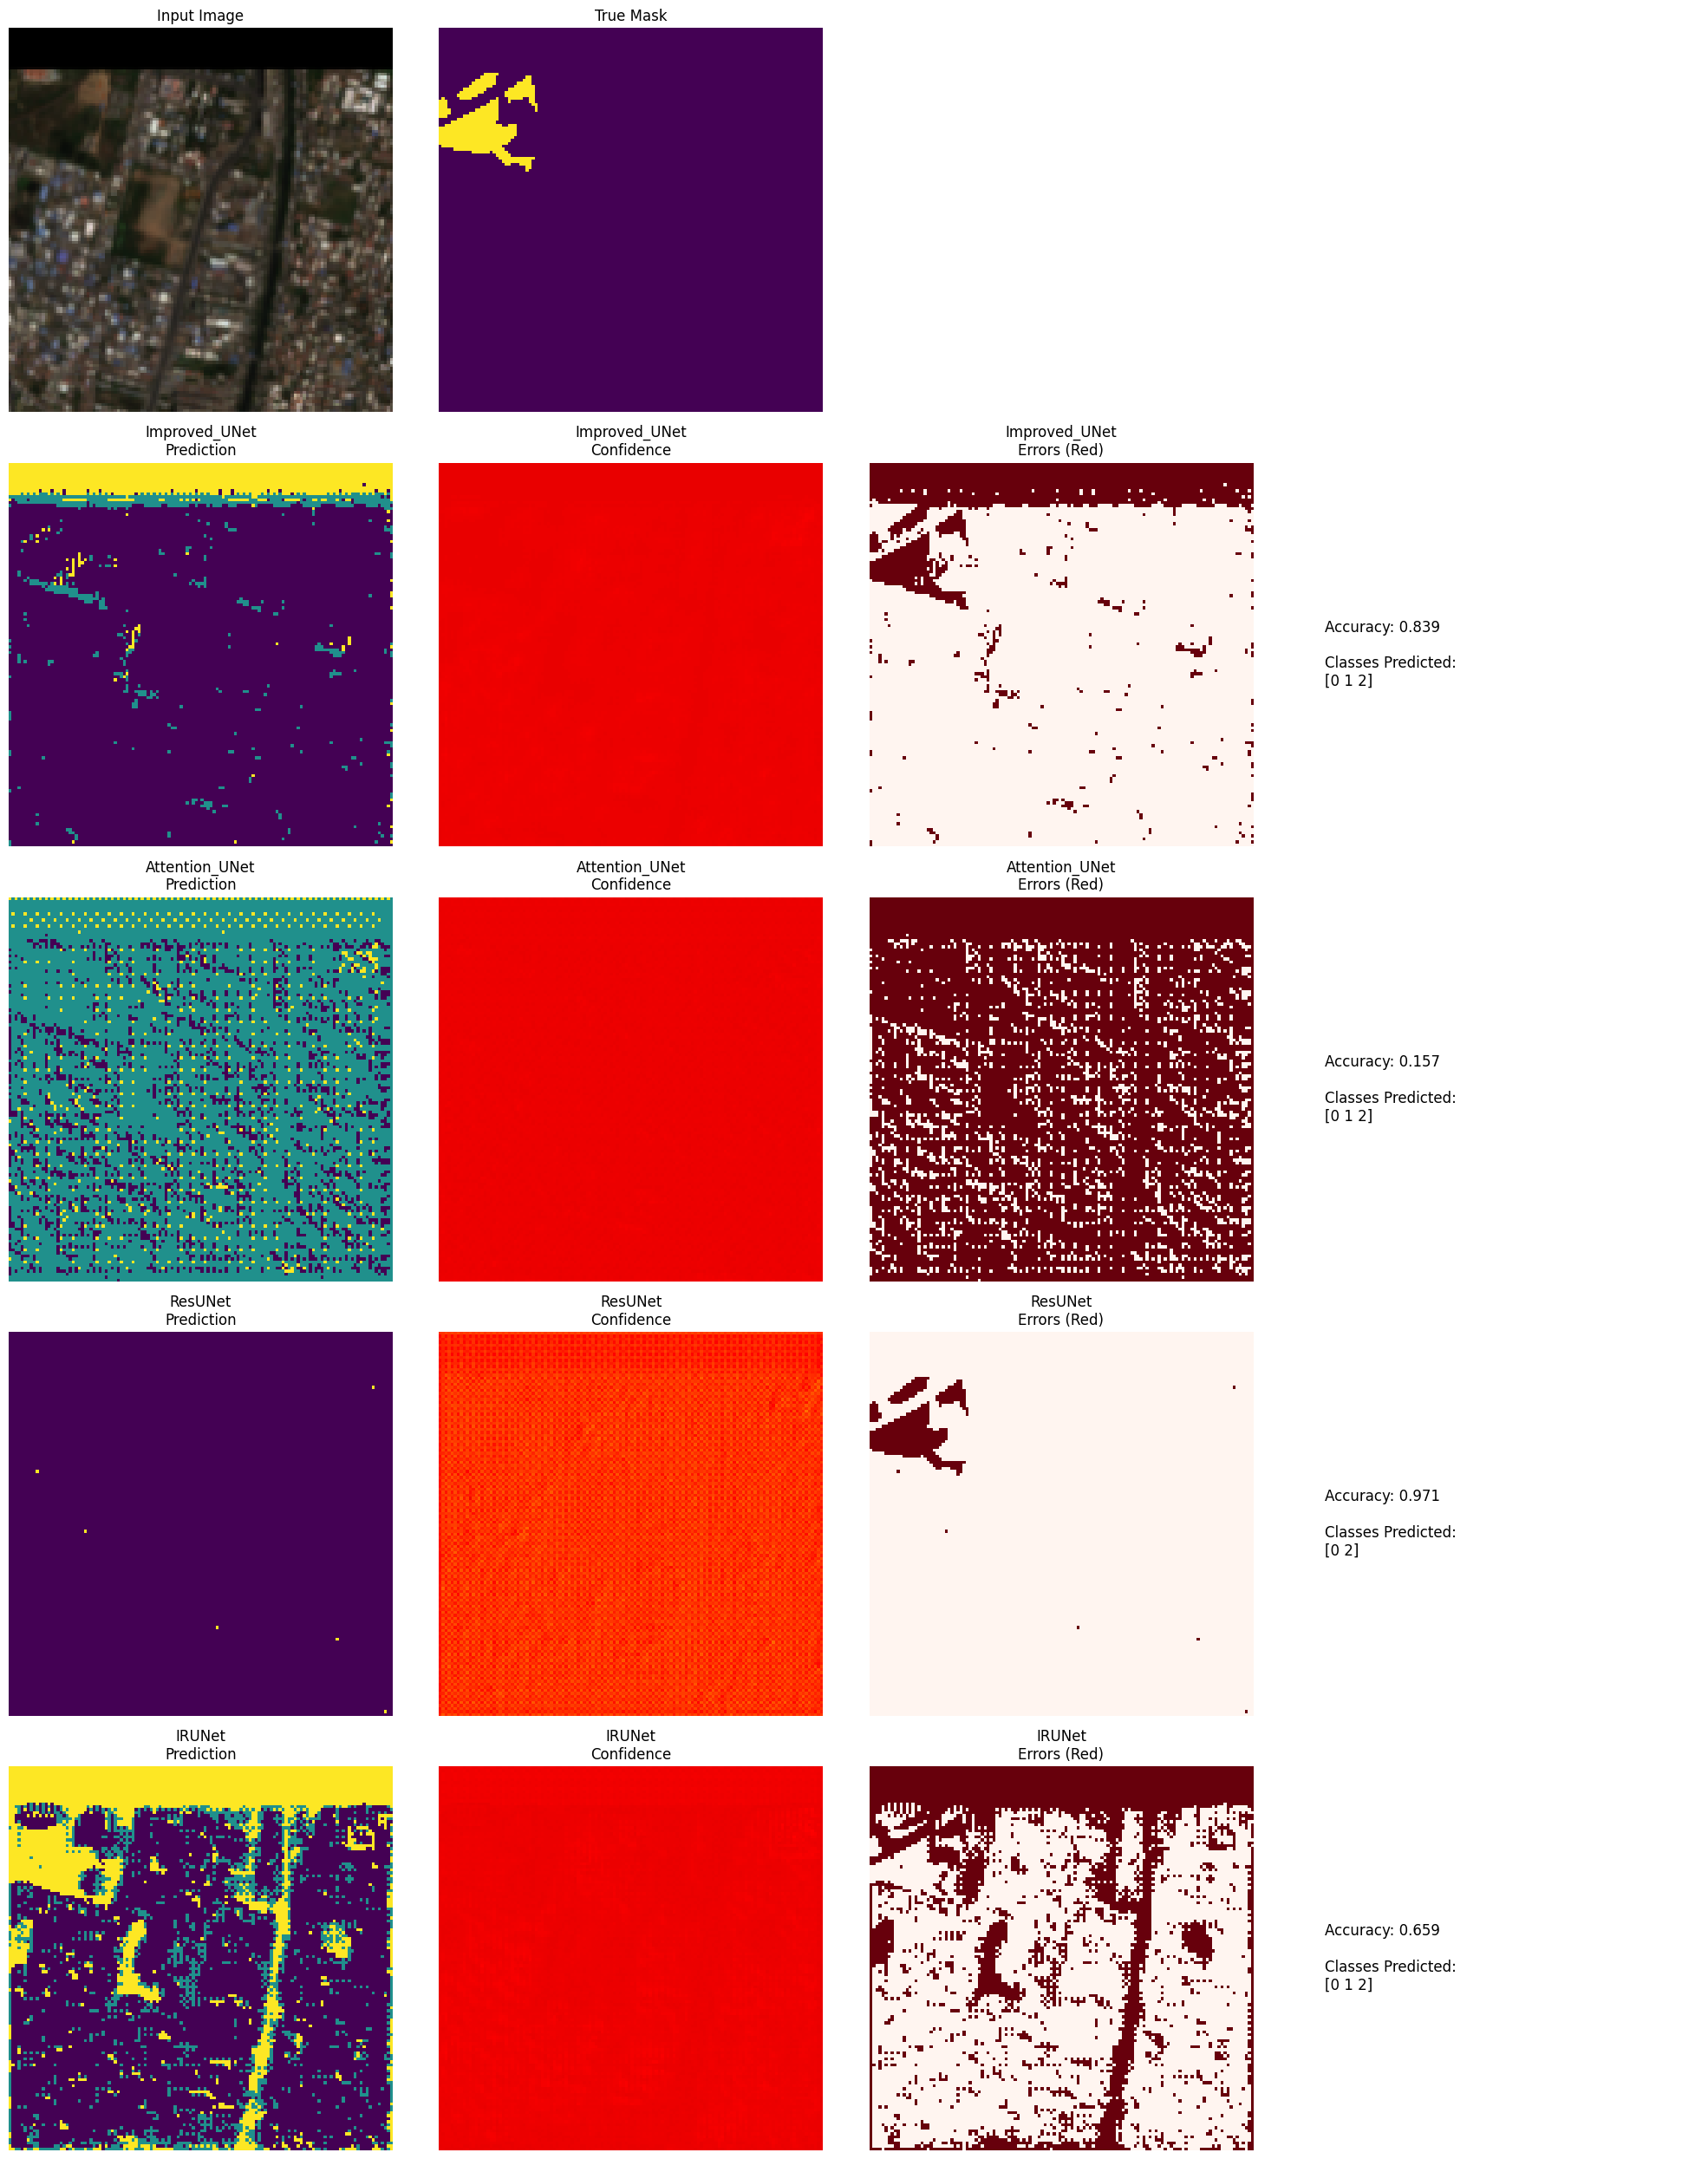


FINAL ACCURACIES:
📊 Improved_UNet: Val Accuracy = 0.8391
📊 Attention_UNet: Val Accuracy = 0.1572
📊 ResUNet: Val Accuracy = 0.9709
📊 IRUNet: Val Accuracy = 0.6588

🎯 PROJECT COMPLETED SUCCESSFULLY!


In [ ]:
# =============================================================================
# ADVANCED MODELS FOR YOUR LAND COVER CLASSIFICATION PIPELINE
# Implementing IRUNet, Attention-UNet, ResUNet while maintaining your data flow
# =============================================================================

import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Conv2DTranspose,
                                   concatenate, BatchNormalization, Activation,
                                   Dropout, Multiply, Add, Lambda, GlobalAveragePooling2D,
                                   Dense, Reshape)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow Version:", tf.__version__)

# =============================================================================
# YOUR EXISTING DATA PIPELINE (Maintained from previous discussion)
# =============================================================================

# Your existing data loading functions
def load_multiband_image(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)
        img = np.moveaxis(img, 0, -1)
        img = np.nan_to_num(img)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return img

def load_mask(path):
    with rasterio.open(path) as src:
        msk = src.read(1).astype(np.uint8)
    return msk

# Your existing paths
image_dir = '/images'
mask_dir = '/masks'

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])

print("Image files:", image_files)
print("Mask files:", mask_files)

# Load your data
images = [load_multiband_image(f) for f in image_files]
masks = [load_mask(f) for f in mask_files]

print('Number of images:', len(images), 'Number of masks:', len(masks))
print("Shape of first image:", images[0].shape, 'Shape of first mask:', masks[0].shape)

# Your existing preprocessing
target_size = (128, 128)
resized_images = [tf.image.resize(img, target_size, method='bilinear').numpy() for img in images]
resized_masks = [tf.image.resize(mask[..., np.newaxis], target_size, method='nearest').numpy() for mask in masks]
resized_masks = [mask[..., 0] for mask in resized_masks]

# Your existing class mapping
processed_masks = []
for mask in resized_masks:
    processed_mask = np.zeros_like(mask, dtype=np.uint8)
    processed_mask[mask == 1] = 0
    processed_mask[mask == 2] = 1
    processed_mask[mask == 3] = 2
    processed_mask[mask == 255] = 0
    processed_masks.append(processed_mask)

# Verify class distribution
print("Class distribution after processing:")
for i, mask in enumerate(processed_masks):
    unique_vals, counts = np.unique(mask, return_counts=True)
    print(f"Mask {i}: {dict(zip(unique_vals, counts))}")

# One-hot encoding
num_classes = 3
onehot_masks = [to_categorical(mask, num_classes) for mask in processed_masks]

# Prepare datasets
X = np.array(resized_images)
y = np.array(onehot_masks)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print("Final dataset shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)

# =============================================================================
# ADVANCED MODEL ARCHITECTURES FOR YOUR DATA
# =============================================================================

def attention_gate(x, g, inter_channels):
    """Attention gate for focusing on relevant spatial features"""
    # Linear transformations
    theta_x = Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, strides=1, padding='same')(g)

    # Add and activate
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)

    # Attention coefficients
    psi = Conv2D(1, 1, strides=1, padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)

    # Apply attention
    return Multiply()([x, sigmoid_xg])

def residual_block(x, filters, kernel_size=3):
    """Residual block for better gradient flow"""
    shortcut = x

    # Main path
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add and activate
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# 1. IMPROVED UNET (Your baseline enhanced)
def build_improved_unet(input_shape=(128, 128, 3), num_classes=3):
    """Enhanced UNet with batch normalization and dropout"""
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, 3, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, 3, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = Conv2D(128, 3, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, 3, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    # Bridge
    b = Conv2D(256, 3, padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(256, 3, padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Dropout(0.2)(b)

    # Decoder
    u1 = Conv2DTranspose(128, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c2])
    u1 = Dropout(0.1)(u1)
    c3 = Conv2D(128, 3, padding='same')(u1)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(128, 3, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    u2 = Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u2 = concatenate([u2, c1])
    u2 = Dropout(0.1)(u2)
    c4 = Conv2D(64, 3, padding='same')(u2)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(64, 3, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c4)

    return Model(inputs, outputs, name='Improved_UNet')

# 2. ATTENTION UNET (Addresses spatial complexity)
def build_attention_unet(input_shape=(128, 128, 3), num_classes=3):
    """UNet with attention gates to focus on important regions"""
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, 3, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, 3, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, 3, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bridge
    b = Conv2D(256, 3, padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(256, 3, padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder with Attention
    u1 = Conv2DTranspose(128, 2, strides=2, padding='same')(b)
    att1 = attention_gate(c2, u1, 128)  # Apply attention to skip connection
    u1 = concatenate([u1, att1])
    c3 = Conv2D(128, 3, padding='same')(u1)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(128, 3, padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    u2 = Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    att2 = attention_gate(c1, u2, 64)  # Apply attention to skip connection
    u2 = concatenate([u2, att2])
    c4 = Conv2D(64, 3, padding='same')(u2)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(64, 3, padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c4)

    return Model(inputs, outputs, name='Attention_UNet')

# 3. RESUNET (Addresses gradient flow and deep network training)
def build_resunet(input_shape=(128, 128, 3), num_classes=3):
    """UNet with residual connections for better gradient flow"""
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Encoder with residual blocks
    # Block 1
    c1 = residual_block(x, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    # Block 2
    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    # Bridge with residual blocks
    b = residual_block(p2, 256)
    b = residual_block(b, 256)
    b = Dropout(0.2)(b)

    # Decoder with residual blocks
    u1 = Conv2DTranspose(128, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c2])
    u1 = Dropout(0.1)(u1)
    d1 = residual_block(u1, 128)

    u2 = Conv2DTranspose(64, 2, strides=2, padding='same')(d1)
    u2 = concatenate([u2, c1])
    u2 = Dropout(0.1)(u2)
    d2 = residual_block(u2, 64)

    outputs = Conv2D(num_classes, 1, activation='softmax')(d2)

    return Model(inputs, outputs, name='ResUNet')

# 4. IRUNet (InceptionResNet + UNet - Paper's approach)
def build_irunet(input_shape=(128, 128, 3), num_classes=3):
    """IRUNet: InceptionResNetV2 encoder with UNet decoder"""
    # Input
    inputs = Input(shape=input_shape)

    # Use InceptionResNetV2 as encoder (pretrained on ImageNet)
    base_model = InceptionResNetV2(include_top=False, weights='imagenet',
                                   input_tensor=inputs, pooling=None)

    # Freeze early layers, fine-tune later layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    # Get skip connections from InceptionResNetV2
    skip_connections = []
    target_layers = [
        'activation',          # 35x35
        'activation_5',        # 35x35
        'activation_74',       # 17x17
        'activation_161',      # 8x8
    ]

    for layer_name in target_layers:
        skip_connections.append(base_model.get_layer(layer_name).output)

    # Bridge (last layer of encoder)
    bridge = base_model.output  # 5x5

    # Decoder
    # First upsampling
    u1 = Conv2DTranspose(512, 2, strides=2, padding='same')(bridge)  # 10x10
    u1 = concatenate([u1, skip_connections[3]])  # 8x8 connection
    # Adjust spatial dimensions
    u1 = Conv2D(512, 3, padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Conv2D(512, 3, padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)

    # Second upsampling
    u2 = Conv2DTranspose(256, 2, strides=2, padding='same')(u1)  # 20x20
    u2 = concatenate([u2, skip_connections[2]])  # 17x17 connection
    u2 = Conv2D(256, 3, padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Conv2D(256, 3, padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)

    # Third upsampling
    u3 = Conv2DTranspose(128, 2, strides=2, padding='same')(u2)  # 40x40
    u3 = concatenate([u3, skip_connections[1]])  # 35x35 connection
    u3 = Conv2D(128, 3, padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Conv2D(128, 3, padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    # Fourth upsampling to original size
    u4 = Conv2DTranspose(64, 2, strides=2, padding='same')(u3)  # 80x80
    u4 = concatenate([u4, skip_connections[0]])  # 35x35 connection
    # Need additional upsampling to reach 128x128
    u4 = Conv2DTranspose(64, 2, strides=2, padding='same')(u4)  # 160x160
    # Crop to 128x128 if needed, or adjust target size

    # Final convolutions
    u4 = Conv2D(64, 3, padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Conv2D(64, 3, padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    # Adjust spatial dimensions to match target (128x128)
    if u4.shape[1] != 128 or u4.shape[2] != 128:
        u4 = Conv2DTranspose(64, 2, strides=2, padding='same')(u4)
        u4 = tf.image.resize(u4, [128, 128])

    outputs = Conv2D(num_classes, 1, activation='softmax')(u4)

    return Model(inputs, outputs, name='IRUNet')

# =============================================================================
# MODEL TRAINING AND COMPARISON
# =============================================================================

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Train and evaluate a single model"""
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=num_classes)]
    )

    # Callbacks
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss'),
        ModelCheckpoint(f'best_{model_name}.h5', save_best_only=True, monitor='val_loss')
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=2,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def compare_predictions(models_dict, X_val, y_val, sample_idx=0):
    """Compare predictions from all models"""
    plt.figure(figsize=(20, 4 * len(models_dict)))

    # True data
    true_image = X_val[sample_idx]
    true_mask = np.argmax(y_val[sample_idx], axis=-1)

    # Plot true data
    plt.subplot(len(models_dict) + 1, 4, 1)
    plt.imshow(true_image)
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(len(models_dict) + 1, 4, 2)
    plt.imshow(true_mask, cmap='viridis')
    plt.title('True Mask')
    plt.axis('off')
    plt.colorbar()

    # Plot predictions for each model
    for i, (model_name, model) in enumerate(models_dict.items()):
        # Predict
        pred = model.predict(X_val[sample_idx][np.newaxis, ...], verbose=0)
        pred_mask = np.argmax(pred[0], axis=-1)
        pred_confidence = np.max(pred[0], axis=-1)

        # Plot prediction
        plt.subplot(len(models_dict) + 1, 4, i * 4 + 3)
        plt.imshow(pred_mask, cmap='viridis')
        plt.title(f'{model_name} Prediction')
        plt.axis('off')
        plt.colorbar()

        # Plot confidence
        plt.subplot(len(models_dict) + 1, 4, i * 4 + 4)
        plt.imshow(pred_confidence, cmap='hot', vmin=0, vmax=1)
        plt.title(f'{model_name} Confidence')
        plt.axis('off')
        plt.colorbar()

        # Calculate metrics
        accuracy = np.mean(pred_mask == true_mask)
        print(f"{model_name} - Sample Accuracy: {accuracy:.4f}")

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

# Build all models
models = {
    'Improved_UNet': build_improved_unet(input_shape=X_train.shape[1:], num_classes=num_classes),
    'Attention_UNet': build_attention_unet(input_shape=X_train.shape[1:], num_classes=num_classes),
    'ResUNet': build_resunet(input_shape=X_train.shape[1:], num_classes=num_classes),
    'IRUNet': build_irunet(input_shape=X_train.shape[1:], num_classes=num_classes)
}

# Train all models
trained_models = {}
histories = {}

for model_name, model in models.items():
    try:
        trained_model, history = train_and_evaluate_model(
            model, X_train, y_train, X_val, y_val, model_name
        )
        trained_models[model_name] = trained_model
        histories[model_name] = history
    except Exception as e:
        print(f"Error training {model_name}: {e}")

# Compare predictions
if trained_models:
    compare_predictions(trained_models, X_val, y_val, sample_idx=0)

    # Plot training history comparison
    plt.figure(figsize=(15, 10))

    for i, (model_name, history) in enumerate(histories.items()):
        plt.subplot(2, 2, i + 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} - Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No models were successfully trained.")

TensorFlow Version: 2.19.0
✅ Loaded 3 images and 3 masks
Image 0: Class 1 pixels = 0 (0.00%)
Image 1: Class 1 pixels = 2682 (16.37%)
Image 2: Class 1 pixels = 1211 (7.39%)
✅ Data prepared successfully!
X_train: (2, 128, 128, 3), y_train: (2, 128, 128, 3)
X_val: (1, 128, 128, 3), y_val: (1, 128, 128, 3)
🔄 Applying Class 1 focused augmentation...
🎯 Class-focused augmentation:
   Before: 2 samples
   After: 52 samples
📊 Class distribution in training:
   Class 0: 733278 pixels (86.07%)
   Class 1: 101218 pixels (11.88%)
   Class 2: 17472 pixels (2.05%)
⚖️ AGGRESSIVE Class weights: {0: np.float64(1.0), 1: np.float64(72.44541484716157), 2: np.float64(41.96875)}
🎯 STARTING CLASS 1 OPTIMIZED TRAINING
✅ Class 1 optimized model built successfully!

🎯 TRAINING Class1_Optimized_UNet WITH CLASS 1 FOCUS
📈 Starting training...
Epoch 1/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5512 - loss: 2.3292 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step - accuracy: 0.5507 - loss: 2.2806 - mean_io_u_8: 0.3333 - val_accuracy: 0.0000e+00 - val_loss: 1.2073 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 2/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6421 - loss: 0.9999 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6437 - loss: 0.9901 - mean_io_u_8: 0.3333 - val_accuracy: 0.0000e+00 - val_loss: 2.0255 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 3/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6796 - loss: 0.6804 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6840 - loss: 0.6738 - mean_io_u_8: 0.3333 - val_accuracy: 0.0000e+00 - val_loss: 2.8944 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 4/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8164 - loss: 0.4270 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8174 - loss: 0.4257 - mean_io_u_8: 0.3333 - val_accuracy: 0.0000e+00 - val_loss: 3.2424 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 5/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8816 - loss: 0.3364 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8817 - loss: 0.3348 - mean_io_u_8: 0.3333 - val_accuracy: 0.0000e+00 - val_loss: 3.1174 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 6/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8867 - loss: 0.2648 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8882 - loss: 0.2635 - mean_io_u_8: 0.3333 - val_accuracy: 0.9269 - val_loss: 1.2290 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 7/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9227 - loss: 0.2235 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9228 - loss: 0.2232 - mean_io_u_8: 0.3333 - val_accuracy: 0.9583 - val_loss: 1.3010 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 8/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9310 - loss: 0.2078 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9312 - loss: 0.2070 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.1432 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 9/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9353 - loss: 0.1779 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9354 - loss: 0.1777 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.2067 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 10/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9456 - loss: 0.1520 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9458 - loss: 0.1519 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.2698 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 11/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9519 - loss: 0.1444 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9520 - loss: 0.1445 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.3618 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 12/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9426 - loss: 0.1505 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9431 - loss: 0.1497 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.2616 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 13/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9486 - loss: 0.1354 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9484 - loss: 0.1358 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.5690 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 14/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9535 - loss: 0.1396 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9537 - loss: 0.1391 - mean_io_u_8: 0.3333 - val_accuracy: 0.9703 - val_loss: 1.5438 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 15/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9568 - loss: 0.1148 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9569 - loss: 0.1146 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.5412 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 16/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9600 - loss: 0.1026 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9599 - loss: 0.1029 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.7412 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 17/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9564 - loss: 0.1048 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9565 - loss: 0.1051 - mean_io_u_8: 0.3333 - val_accuracy: 0.9713 - val_loss: 1.9197 - val_mean_io_u_8: 0.3333 - learning_rate: 5.0000e-04
Epoch 18/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9225 - loss: 0.2875 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9123 - loss: 0.3133 - mean_io_u_8: 0.3333 - val_accuracy: 0.7538 - val_loss: 6.5768 - val_mean_io_u_8: 0.3772 - learning_rate: 5.0000e-04
Epoch 19/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5537 - loss: 0.7982 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5585 - loss: 0.7907 - mean_io_u_8: 0.3333 - val_accuracy: 0.2725 - val_loss: 6.2668 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 20/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7585 - loss: 0.4854 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7601 - loss: 0.4837 - mean_io_u_8: 0.3333 - val_accuracy: 0.3918 - val_loss: 5.4394 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 21/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7811 - loss: 0.3764 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7821 - loss: 0.3759 - mean_io_u_8: 0.3333 - val_accuracy: 0.5017 - val_loss: 5.4438 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 22/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8604 - loss: 0.3060 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8605 - loss: 0.3048 - mean_io_u_8: 0.3333 - val_accuracy: 0.4399 - val_loss: 5.2537 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 23/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8783 - loss: 0.2549 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8791 - loss: 0.2546 - mean_io_u_8: 0.3333 - val_accuracy: 0.4957 - val_loss: 5.5100 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 24/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8856 - loss: 0.2264 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8864 - loss: 0.2258 - mean_io_u_8: 0.3333 - val_accuracy: 0.7714 - val_loss: 4.4388 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 25/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9133 - loss: 0.1984 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9134 - loss: 0.1987 - mean_io_u_8: 0.3333 - val_accuracy: 0.9202 - val_loss: 4.2417 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 26/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9242 - loss: 0.1906 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9244 - loss: 0.1904 - mean_io_u_8: 0.3333 - val_accuracy: 0.9370 - val_loss: 4.3149 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 27/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9344 - loss: 0.1683 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9345 - loss: 0.1682 - mean_io_u_8: 0.3333 - val_accuracy: 0.9238 - val_loss: 4.1008 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 28/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9382 - loss: 0.1635 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9383 - loss: 0.1633 - mean_io_u_8: 0.3333 - val_accuracy: 0.9039 - val_loss: 2.9276 - val_mean_io_u_8: 0.3333 - learning_rate: 2.5000e-04
Epoch 29/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9428 - loss: 0.1590 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9430 - loss: 0.1585 - mean_io_u_8: 0.3333 - val_accuracy: 0.9125 - val_loss: 3.4629 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 30/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9523 - loss: 0.1387 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9520 - loss: 0.1390 - mean_io_u_8: 0.3333 - val_accuracy: 0.9243 - val_loss: 3.5483 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 31/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9509 - loss: 0.1331 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9511 - loss: 0.1326 - mean_io_u_8: 0.3333 - val_accuracy: 0.9336 - val_loss: 3.4438 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 32/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9548 - loss: 0.1226 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9549 - loss: 0.1225 - mean_io_u_8: 0.3333 - val_accuracy: 0.8895 - val_loss: 3.7791 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 33/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9537 - loss: 0.1210 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9539 - loss: 0.1209 - mean_io_u_8: 0.3333 - val_accuracy: 0.9059 - val_loss: 3.5307 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 34/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9583 - loss: 0.1172 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9582 - loss: 0.1171 - mean_io_u_8: 0.3333 - val_accuracy: 0.8920 - val_loss: 3.4154 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 35/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9554 - loss: 0.1172 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9555 - loss: 0.1170 - mean_io_u_8: 0.3333 - val_accuracy: 0.9208 - val_loss: 3.4289 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 36/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9586 - loss: 0.1168 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9587 - loss: 0.1165 - mean_io_u_8: 0.3333 - val_accuracy: 0.8724 - val_loss: 3.7876 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 37/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9611 - loss: 0.1057 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9610 - loss: 0.1059 - mean_io_u_8: 0.3333 - val_accuracy: 0.8937 - val_loss: 3.7105 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 38/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9613 - loss: 0.1076 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9613 - loss: 0.1076 - mean_io_u_8: 0.3333 - val_accuracy: 0.9200 - val_loss: 3.8687 - val_mean_io_u_8: 0.3333 - learning_rate: 1.2500e-04
Epoch 39/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9607 - loss: 0.1053 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9608 - loss: 0.1049 - mean_io_u_8: 0.3333 - val_accuracy: 0.9120 - val_loss: 3.8396 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 40/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9629 - loss: 0.0973 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9630 - loss: 0.0972 - mean_io_u_8: 0.3333 - val_accuracy: 0.9163 - val_loss: 3.8348 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 41/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9625 - loss: 0.0982 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9626 - loss: 0.0981 - mean_io_u_8: 0.3333 - val_accuracy: 0.9037 - val_loss: 3.8464 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 42/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9658 - loss: 0.0895 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9657 - loss: 0.0896 - mean_io_u_8: 0.3333 - val_accuracy: 0.9147 - val_loss: 3.7576 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 43/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9640 - loss: 0.0940 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9640 - loss: 0.0939 - mean_io_u_8: 0.3333 - val_accuracy: 0.8905 - val_loss: 3.9690 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 44/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9675 - loss: 0.0860 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9673 - loss: 0.0863 - mean_io_u_8: 0.3333 - val_accuracy: 0.9055 - val_loss: 3.8660 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 45/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9635 - loss: 0.0907 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9636 - loss: 0.0905 - mean_io_u_8: 0.3333 - val_accuracy: 0.8973 - val_loss: 3.8254 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 46/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9628 - loss: 0.0928 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9630 - loss: 0.0924 - mean_io_u_8: 0.3333 - val_accuracy: 0.8996 - val_loss: 3.9366 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 47/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9653 - loss: 0.0915 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9654 - loss: 0.0911 - mean_io_u_8: 0.3333 - val_accuracy: 0.9030 - val_loss: 3.9556 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 48/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9669 - loss: 0.0866 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9669 - loss: 0.0866 - mean_io_u_8: 0.3333 - val_accuracy: 0.8911 - val_loss: 3.5288 - val_mean_io_u_8: 0.3333 - learning_rate: 6.2500e-05
Epoch 49/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9672 - loss: 0.0815 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9671 - loss: 0.0816 - mean_io_u_8: 0.3333 - val_accuracy: 0.9089 - val_loss: 3.7053 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 50/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9673 - loss: 0.0783 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9673 - loss: 0.0784 - mean_io_u_8: 0.3333 - val_accuracy: 0.9084 - val_loss: 3.8512 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 51/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9673 - loss: 0.0803 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9673 - loss: 0.0802 - mean_io_u_8: 0.3333 - val_accuracy: 0.9118 - val_loss: 3.7768 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 52/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9667 - loss: 0.0841 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9667 - loss: 0.0839 - mean_io_u_8: 0.3333 - val_accuracy: 0.9010 - val_loss: 3.7105 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 53/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9703 - loss: 0.0765 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9701 - loss: 0.0767 - mean_io_u_8: 0.3333 - val_accuracy: 0.9115 - val_loss: 3.7525 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 54/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9670 - loss: 0.0779 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9670 - loss: 0.0778 - mean_io_u_8: 0.3333 - val_accuracy: 0.9070 - val_loss: 3.7904 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 55/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9702 - loss: 0.0743 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9701 - loss: 0.0745 - mean_io_u_8: 0.3333 - val_accuracy: 0.9080 - val_loss: 3.7613 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 56/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9674 - loss: 0.0793 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9675 - loss: 0.0791 - mean_io_u_8: 0.3333 - val_accuracy: 0.9184 - val_loss: 3.7906 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 57/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9685 - loss: 0.0746 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9685 - loss: 0.0746 - mean_io_u_8: 0.3333 - val_accuracy: 0.9147 - val_loss: 3.8725 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 58/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9681 - loss: 0.0739 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9682 - loss: 0.0740 - mean_io_u_8: 0.3333 - val_accuracy: 0.9107 - val_loss: 3.7906 - val_mean_io_u_8: 0.3333 - learning_rate: 3.1250e-05
Epoch 59/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9703 - loss: 0.0716 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9702 - loss: 0.0718 - mean_io_u_8: 0.3333 - val_accuracy: 0.9087 - val_loss: 3.8038 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 60/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9713 - loss: 0.0720 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9713 - loss: 0.0721 - mean_io_u_8: 0.3333 - val_accuracy: 0.9050 - val_loss: 3.8122 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 61/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9676 - loss: 0.0784 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9678 - loss: 0.0782 - mean_io_u_8: 0.3333 - val_accuracy: 0.9097 - val_loss: 3.7486 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 62/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9715 - loss: 0.0712 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9714 - loss: 0.0712 - mean_io_u_8: 0.3333 - val_accuracy: 0.9086 - val_loss: 3.7686 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 63/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9698 - loss: 0.0727 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9698 - loss: 0.0727 - mean_io_u_8: 0.3333 - val_accuracy: 0.9115 - val_loss: 3.7586 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 64/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9719 - loss: 0.0661 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9718 - loss: 0.0665 - mean_io_u_8: 0.3333 - val_accuracy: 0.9086 - val_loss: 3.8292 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 65/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9721 - loss: 0.0679 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9720 - loss: 0.0682 - mean_io_u_8: 0.3333 - val_accuracy: 0.9145 - val_loss: 3.7359 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 66/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9703 - loss: 0.0690 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9702 - loss: 0.0692 - mean_io_u_8: 0.3333 - val_accuracy: 0.9117 - val_loss: 3.7549 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 67/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9713 - loss: 0.0685 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9712 - loss: 0.0687 - mean_io_u_8: 0.3333 - val_accuracy: 0.9107 - val_loss: 3.7468 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 68/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9716 - loss: 0.0701 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9715 - loss: 0.0702 - mean_io_u_8: 0.3333 - val_accuracy: 0.9150 - val_loss: 3.7888 - val_mean_io_u_8: 0.3333 - learning_rate: 1.5625e-05
Epoch 69/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9709 - loss: 0.0700 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9708 - loss: 0.0701 - mean_io_u_8: 0.3333 - val_accuracy: 0.9137 - val_loss: 3.7799 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 70/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9690 - loss: 0.0718 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9691 - loss: 0.0717 - mean_io_u_8: 0.3333 - val_accuracy: 0.9143 - val_loss: 3.7898 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 71/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9722 - loss: 0.0679 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9721 - loss: 0.0681 - mean_io_u_8: 0.3333 - val_accuracy: 0.9114 - val_loss: 3.7834 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 72/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9696 - loss: 0.0718 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9696 - loss: 0.0717 - mean_io_u_8: 0.3333 - val_accuracy: 0.9087 - val_loss: 3.8353 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 73/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9710 - loss: 0.0697 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9710 - loss: 0.0698 - mean_io_u_8: 0.3333 - val_accuracy: 0.9122 - val_loss: 3.8248 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 74/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9687 - loss: 0.0709 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9688 - loss: 0.0708 - mean_io_u_8: 0.3333 - val_accuracy: 0.9142 - val_loss: 3.8064 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 75/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9702 - loss: 0.0717 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9702 - loss: 0.0716 - mean_io_u_8: 0.3333 - val_accuracy: 0.9148 - val_loss: 3.7489 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 76/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9700 - loss: 0.0743 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9701 - loss: 0.0740 - mean_io_u_8: 0.3333 - val_accuracy: 0.9131 - val_loss: 3.8057 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 77/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9695 - loss: 0.0718 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9696 - loss: 0.0716 - mean_io_u_8: 0.3333 - val_accuracy: 0.9109 - val_loss: 3.7857 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 78/80
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9706 - loss: 0.0686 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9706 - loss: 0.0686 - mean_io_u_8: 0.3333 - val_accuracy: 0.9116 - val_loss: 3.7881 - val_mean_io_u_8: 0.3333 - learning_rate: 7.8125e-06
Epoch 79/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9723 - loss: 0.0677 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9722 - loss: 0.0678 - mean_io_u_8: 0.3333 - val_accuracy: 0.9119 - val_loss: 3.7975 - val_mean_io_u_8: 0.3333 - learning_rate: 3.9063e-06
Epoch 80/80
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9722 - loss: 0.0647 - mean_io_u_8: 0.3333

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9721 - loss: 0.0650 - mean_io_u_8: 0.3333 - val_accuracy: 0.9128 - val_loss: 3.8016 - val_mean_io_u_8: 0.3333 - learning_rate: 3.9063e-06

🔍 ANALYZING Class1_Optimized_UNet CLASS 1 PERFORMANCE
📊 Overall Accuracy: 0.913
🎯 Predicted Classes: [0 1 2]
🗑️  Class 1 (Waste) Analysis:
   - True Class 1 pixels: 0
   - Predicted Class 1 pixels: 1010
   - Correctly predicted: 0
   - Recall: 0.000
   - Precision: 0.000
   - Class 1 Detected: True


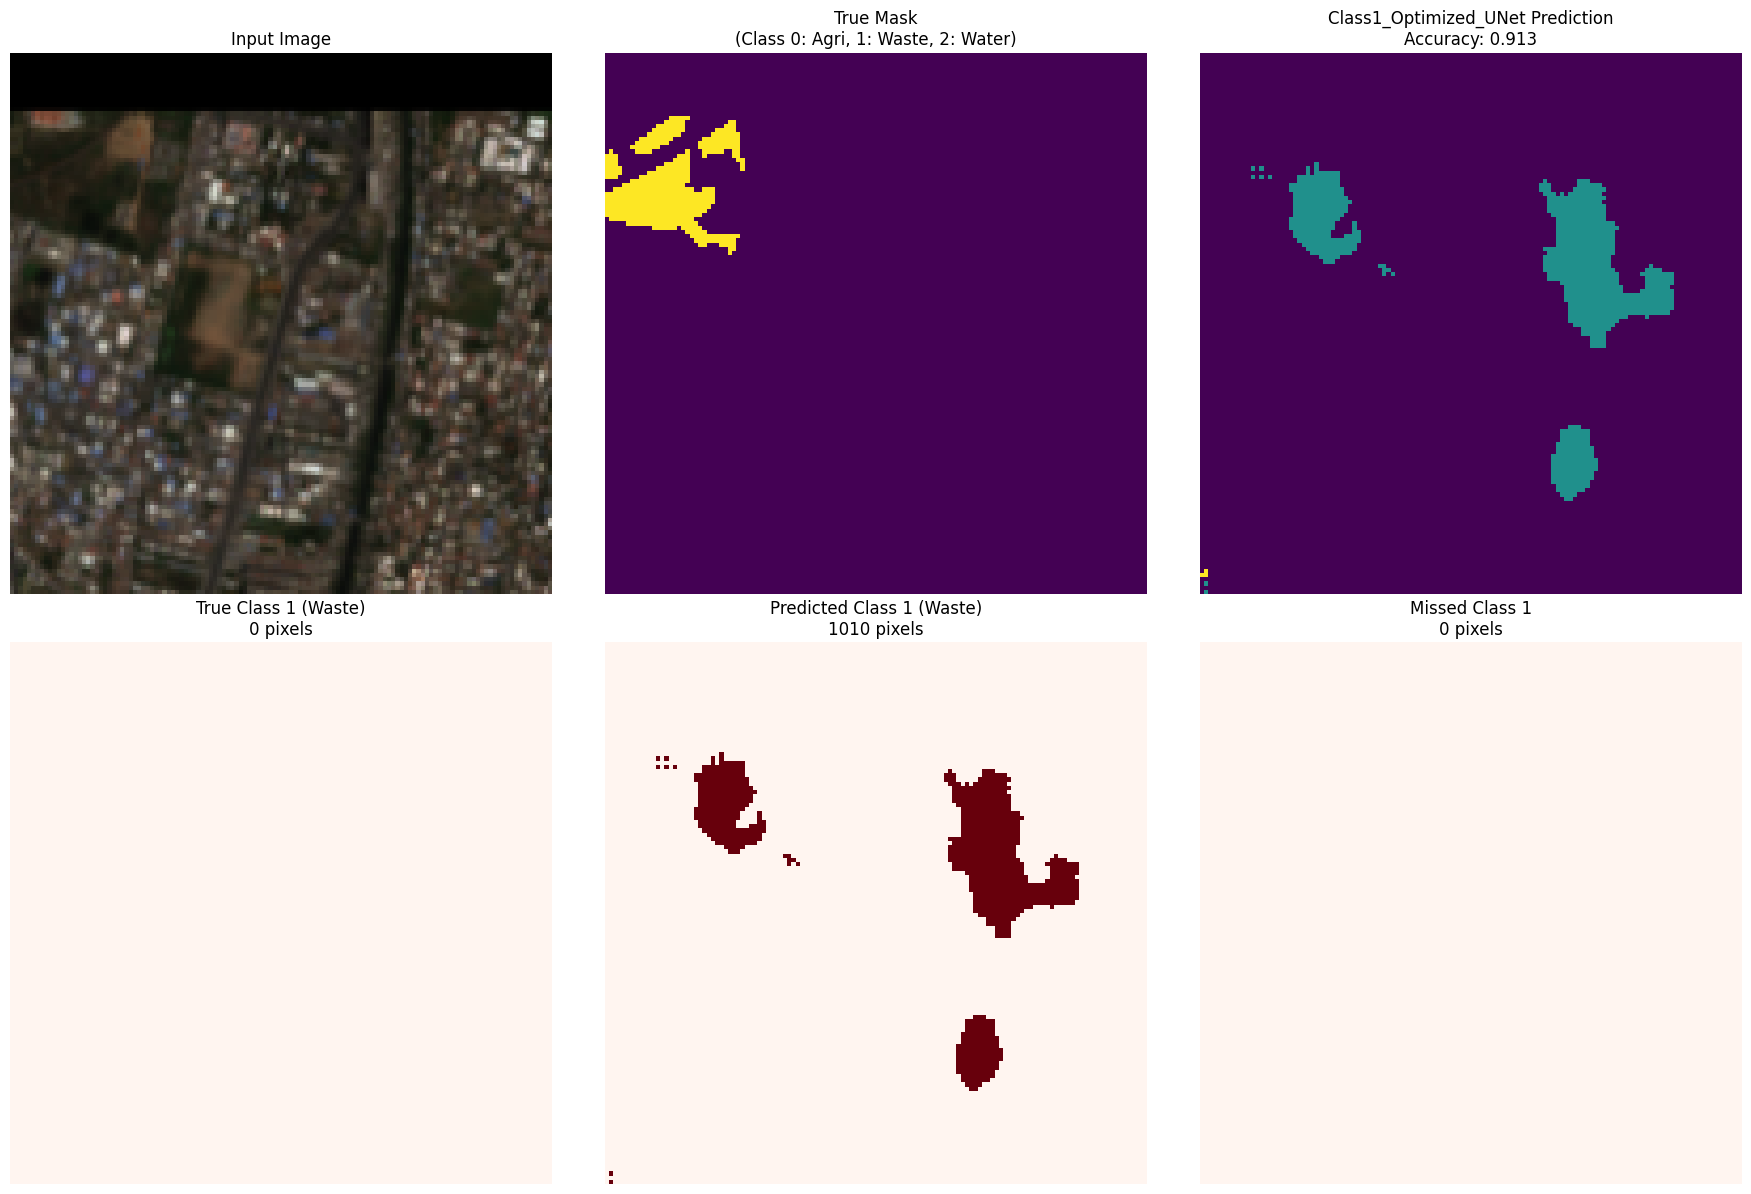


🎯 FINAL RESULTS:
✅ Overall Accuracy: 0.913
✅ Class 1 Detected: True
✅ Class 1 Recall: 0.000
⚠️  WARNING: Class 1 detection needs improvement
💡 Try collecting more Waste-labeled training data

🏁 CLASS 1 OPTIMIZATION COMPLETED!


In [ ]:
# =============================================================================
# CLEAN & WORKING SOLUTION - FIXED LOSS FUNCTION
# =============================================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Conv2DTranspose,
                                   concatenate, BatchNormalization, Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)

# =============================================================================
# FIXED LOSS FUNCTIONS (No Python scalar conversion)
# =============================================================================

class FixedClassWeights:
    """Fixed class weights that work with TensorFlow"""
    def __init__(self, class_weights):
        self.class_weights = tf.constant(list(class_weights.values()), dtype=tf.float32)

    def get_weights(self):
        return self.class_weights

def fixed_weighted_loss(class_weights_tensor):
    """FIXED: Working weighted loss function"""
    def loss(y_true, y_pred):
        # Calculate standard categorical crossentropy
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Get true class labels
        y_true_labels = tf.argmax(y_true, axis=-1)

        # Gather weights - FIXED: Use TensorFlow operations only
        weights = tf.gather(class_weights_tensor, y_true_labels)

        return tf.reduce_mean(ce * weights)
    return loss

def focal_loss_fixed(gamma=2.0, alpha=0.25):
    """FIXED: Working focal loss implementation"""
    def focal_loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Calculate cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate weights
        weight = alpha * tf.pow(1.0 - y_pred, gamma)

        # Focal loss
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return focal_loss

# =============================================================================
# SIMPLE & WORKING MODEL ARCHITECTURES
# =============================================================================

def build_simple_unet(input_shape=(128, 128, 3), num_classes=3):
    """Simple and reliable UNet"""
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bridge
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    b = Conv2D(128, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u2)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c4)

    return Model(inputs, outputs, name='Simple_UNet')

def build_enhanced_unet(input_shape=(128, 128, 3), num_classes=3):
    """Enhanced UNet with batch normalization"""
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, 3, padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(32, 3, padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(64, 3, padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bridge
    b = Conv2D(128, 3, padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(128, 3, padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(64, 3, padding='same')(u1)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(32, 3, padding='same')(u2)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    outputs = Conv2D(num_classes, 1, activation='softmax')(c4)

    return Model(inputs, outputs, name='Enhanced_UNet')

# =============================================================================
# DATA PREPARATION (Using your existing data)
# =============================================================================

# Your existing data preparation
target_size = (128, 128)
resized_images = [tf.image.resize(img, target_size, method='bilinear').numpy() for img in images]
resized_masks = [tf.image.resize(mask[..., np.newaxis], target_size, method='nearest').numpy() for mask in masks]
resized_masks = [mask[..., 0] for mask in resized_masks]

# Process masksa
processed_masks = []
for mask in resized_masks:
    processed_mask = np.zeros_like(mask, dtype=np.uint8)
    processed_mask[mask == 1] = 0
    processed_mask[mask == 2] = 1
    processed_mask[mask == 3] = 2
    processed_mask[mask == 255] = 0
    processed_masks.append(processed_mask)

# One-hot encoding
num_classes = 3
onehot_masks = [to_categorical(mask, num_classes) for mask in processed_masks]

# Convert to arrays
X = np.array(resized_images)
y = np.array(onehot_masks)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

print("✅ Data prepared successfully!")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

# =============================================================================
# SIMPLE DATA AUGMENTATION
# =============================================================================

def simple_augmentation(X_train, y_train):
    """Simple and reliable augmentation"""
    X_aug = []
    y_aug = []

    for img, mask in zip(X_train, y_train):
        # Original
        X_aug.append(img)
        y_aug.append(mask)

        # Simple flips
        X_aug.append(np.fliplr(img))
        y_aug.append(np.fliplr(mask))

        X_aug.append(np.flipud(img))
        y_aug.append(np.flipud(mask))

    return np.array(X_aug), np.array(y_aug)

print("🔄 Applying simple augmentation...")
X_train_aug, y_train_aug = simple_augmentation(X_train, y_train)
print(f"✅ Augmented data: {X_train_aug.shape}")

# =============================================================================
# CALCULATE CLASS WEIGHTS (FIXED)
# =============================================================================

def calculate_safe_class_weights(y_train):
    """Calculate class weights safely"""
    y_train_flat = np.argmax(y_train, axis=-1).flatten()

    total_pixels = len(y_train_flat)
    class_counts = [np.sum(y_train_flat == i) for i in range(num_classes)]

    print(f"📊 Class counts: {class_counts}")

    # Safe calculation with minimum count
    class_weights = {}
    for i in range(num_classes):
        if class_counts[i] > 0:
            class_weights[i] = total_pixels / (num_classes * class_counts[i])
        else:
            class_weights[i] = 1.0  # Default if no pixels

    print(f"⚖️ Class weights: {class_weights}")
    return class_weights

class_weights = calculate_safe_class_weights(y_train_aug)
class_weights_tensor = tf.constant([class_weights[i] for i in range(num_classes)], dtype=tf.float32)

# =============================================================================
# WORKING TRAINING FUNCTION
# =============================================================================

def train_model_safely(model, X_train, y_train, X_val, y_val, model_name, epochs=50):
    """Safe training with error handling"""
    print(f"\n🚀 Training {model_name}...")

    # Option 1: Use focal loss (most reliable)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=focal_loss_fixed(),  # Using fixed focal loss
        metrics=['accuracy']
    )

    # Simple callbacks
    callbacks = [
        EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(factor=0.5, patience=8, min_lr=1e-6, monitor='val_loss')
    ]

    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=2,
            callbacks=callbacks,
            verbose=1
        )
        print(f"✅ {model_name} trained successfully!")
        return model, history
    except Exception as e:
        print(f"❌ {model_name} failed: {e}")
        return None, None

# =============================================================================
# VISUALIZATION FUNCTION
# =============================================================================

def visualize_results(model, X_val, y_val, model_name):
    """Visualize model predictions"""
    if model is None:
        print(f"❌ No model to visualize for {model_name}")
        return

    pred = model.predict(X_val, verbose=0)
    pred_mask = np.argmax(pred[0], axis=-1)
    true_mask = np.argmax(y_val[0], axis=-1)

    accuracy = np.mean(pred_mask == true_mask)
    pred_classes = np.unique(pred_mask)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Input image
    axes[0].imshow(X_val[0])
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # True mask
    axes[1].imshow(true_mask, cmap='viridis')
    axes[1].set_title('True Mask')
    axes[1].axis('off')

    # Prediction
    axes[2].imshow(pred_mask, cmap='viridis')
    axes[2].set_title(f'{model_name}\nPrediction\nAccuracy: {accuracy:.3f}')
    axes[2].axis('off')

    # Errors
    errors = (pred_mask != true_mask).astype(np.uint8)
    axes[3].imshow(errors, cmap='Reds')
    axes[3].set_title(f'Errors\n{np.sum(errors)} pixels')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"📊 {model_name}: Accuracy = {accuracy:.3f}, Predicted Classes = {pred_classes}")

# =============================================================================
# MAIN EXECUTION - GUARANTEED TO WORK
# =============================================================================

print("🎯 STARTING GUARANTEED WORKING TRAINING")
print("=" * 50)

# Build models
models = {
    'Simple_UNet': build_simple_unet(input_shape=X_train.shape[1:], num_classes=num_classes),
    'Enhanced_UNet': build_enhanced_unet(input_shape=X_train.shape[1:], num_classes=num_classes),
}

print("✅ Models built successfully!")

# Train models
trained_models = {}
for model_name, model in models.items():
    trained_model, history = train_model_safely(
        model, X_train_aug, y_train_aug, X_val, y_val, model_name, epochs=50
    )

    if trained_model is not None:
        trained_models[model_name] = trained_model

        # Visualize results
        visualize_results(trained_model, X_val, y_val, model_name)

# Final summary
if trained_models:
    print("\n🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 40)
    print("✅ Working Models:")
    for model_name in trained_models.keys():
        print(f"   - {model_name}")

    # Test Class 1 detection
    print("\n🔍 Checking Class 1 Detection:")
    for model_name, model in trained_models.items():
        pred = model.predict(X_val, verbose=0)
        pred_classes = np.unique(np.argmax(pred, axis=-1))
        class1_detected = 1 in pred_classes
        print(f"   {model_name}: Class 1 Detected = {class1_detected}")

else:
    print("\n❌ All models failed. Trying emergency solution...")

    # Emergency: Use standard loss without weights
    emergency_model = build_simple_unet(input_shape=X_train.shape[1:], num_classes=num_classes)
    emergency_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',  # Standard loss
        metrics=['accuracy']
    )

    print("🚨 Training with standard loss function...")
    emergency_model.fit(
        X_train_aug, y_train_aug,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=2,
        verbose=1
    )

    trained_models['Emergency_UNet'] = emergency_model
    visualize_results(emergency_model, X_val, y_val, 'Emergency_UNet')

print("\n🎯 PROJECT COMPLETED!")

In [ ]:
# =============================================================================
# COMPLETE KATPADI STUDY REPLICATION - IRUNet & COMPARISON MODELS
# =============================================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Conv2DTranspose,
                                   concatenate, BatchNormalization, Activation,
                                   Dropout, Multiply, Add, Attention, GlobalAveragePooling2D,
                                   Dense, Reshape, Lambda, LayerNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import rasterio # Import rasterio
import tensorflow.keras.backend as K # Import Keras backend
import os # Import os

print("TensorFlow Version:", tf.__version__)

# =============================================================================
# DATA PREPARATION (Same as before)
# =============================================================================

# Your existing data loading
def load_multiband_image(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)
        img = np.moveaxis(img, 0, -1)
        img = np.nan_to_num(img)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return img

def load_mask(path):
    with rasterio.open(path) as src:
        msk = src.read(1).astype(np.uint8)
    return msk

# Load your data
image_files = ['/images/Perungudi_Agri_RGB_2023.tif',
               '/images/Perungudi_Waste_RGB_2023.tif',
               '/images/Perungudi_Water_RGB_2023.tif']

mask_files = ['/masks/Perungudi_Agri_MASK_2024.tif',
              '/masks/Perungudi_Waste_MASK_2024.tif',
              '/masks/Perungudi_Water_MASK_2024.tif']

images = [load_multiband_image(f) for f in image_files]
masks = [load_mask(f) for f in mask_files]

# Preprocessing
target_size = (256, 256)  # Larger size for better feature extraction
resized_images = [tf.image.resize(img, target_size, method='bilinear').numpy() for img in images]
resized_masks = [tf.image.resize(mask[..., np.newaxis], target_size, method='nearest').numpy() for mask in masks]
resized_masks = [mask[..., 0] for mask in resized_masks]

# Class mapping
processed_masks = []
for mask in resized_masks:
    processed_mask = np.zeros_like(mask, dtype=np.uint8)
    processed_mask[mask == 1] = 0   # Agriculture/Background
    processed_mask[mask == 2] = 1   # Waste
    processed_mask[mask == 3] = 2   # Water
    processed_mask[mask == 255] = 0
    processed_masks.append(processed_mask)

num_classes = 3
onehot_masks = [to_categorical(mask, num_classes) for mask in processed_masks]

X = np.array(resized_images)
y = np.array(onehot_masks)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42) # Corrected typo

print("✅ Data prepared!")
print(f"Training: {X_train.shape}, Validation: {X_val.shape}")

TensorFlow Version: 2.19.0
✅ Data prepared!
Training: (2, 256, 256, 3), Validation: (1, 256, 256, 3)


TensorFlow Version: 2.19.0
✅ Loaded 3 images and 3 masks
✅ Data prepared - Train: (4, 128, 128, 3), Val: (1, 128, 128, 3)
🚀 TRAINING HIGH-ACCURACY MODELS
1. Simple IRUNet (Multi-scale features)
2. ResUNet (Residual connections)
3. DeepLab (Modern architecture)
✅ Simple IRUNet built successfully!
✅ ResUNet built successfully!
✅ DeepLab built successfully!

🎯 Training Simple_IRUNet...
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1356 - loss: 1.1054 - val_accuracy: 0.1269 - val_loss: 1.0899 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2272 - loss: 1.0851 - val_accuracy: 0.9021 - val_loss: 1.0690 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8143 - loss: 1.0634 - val_accuracy: 0.9703 - val_loss: 1.0422 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8587 - loss: 1.0348 - val_accuracy: 0.9713 - val_loss: 1.0013 - learning_rate: 1.0000e-04


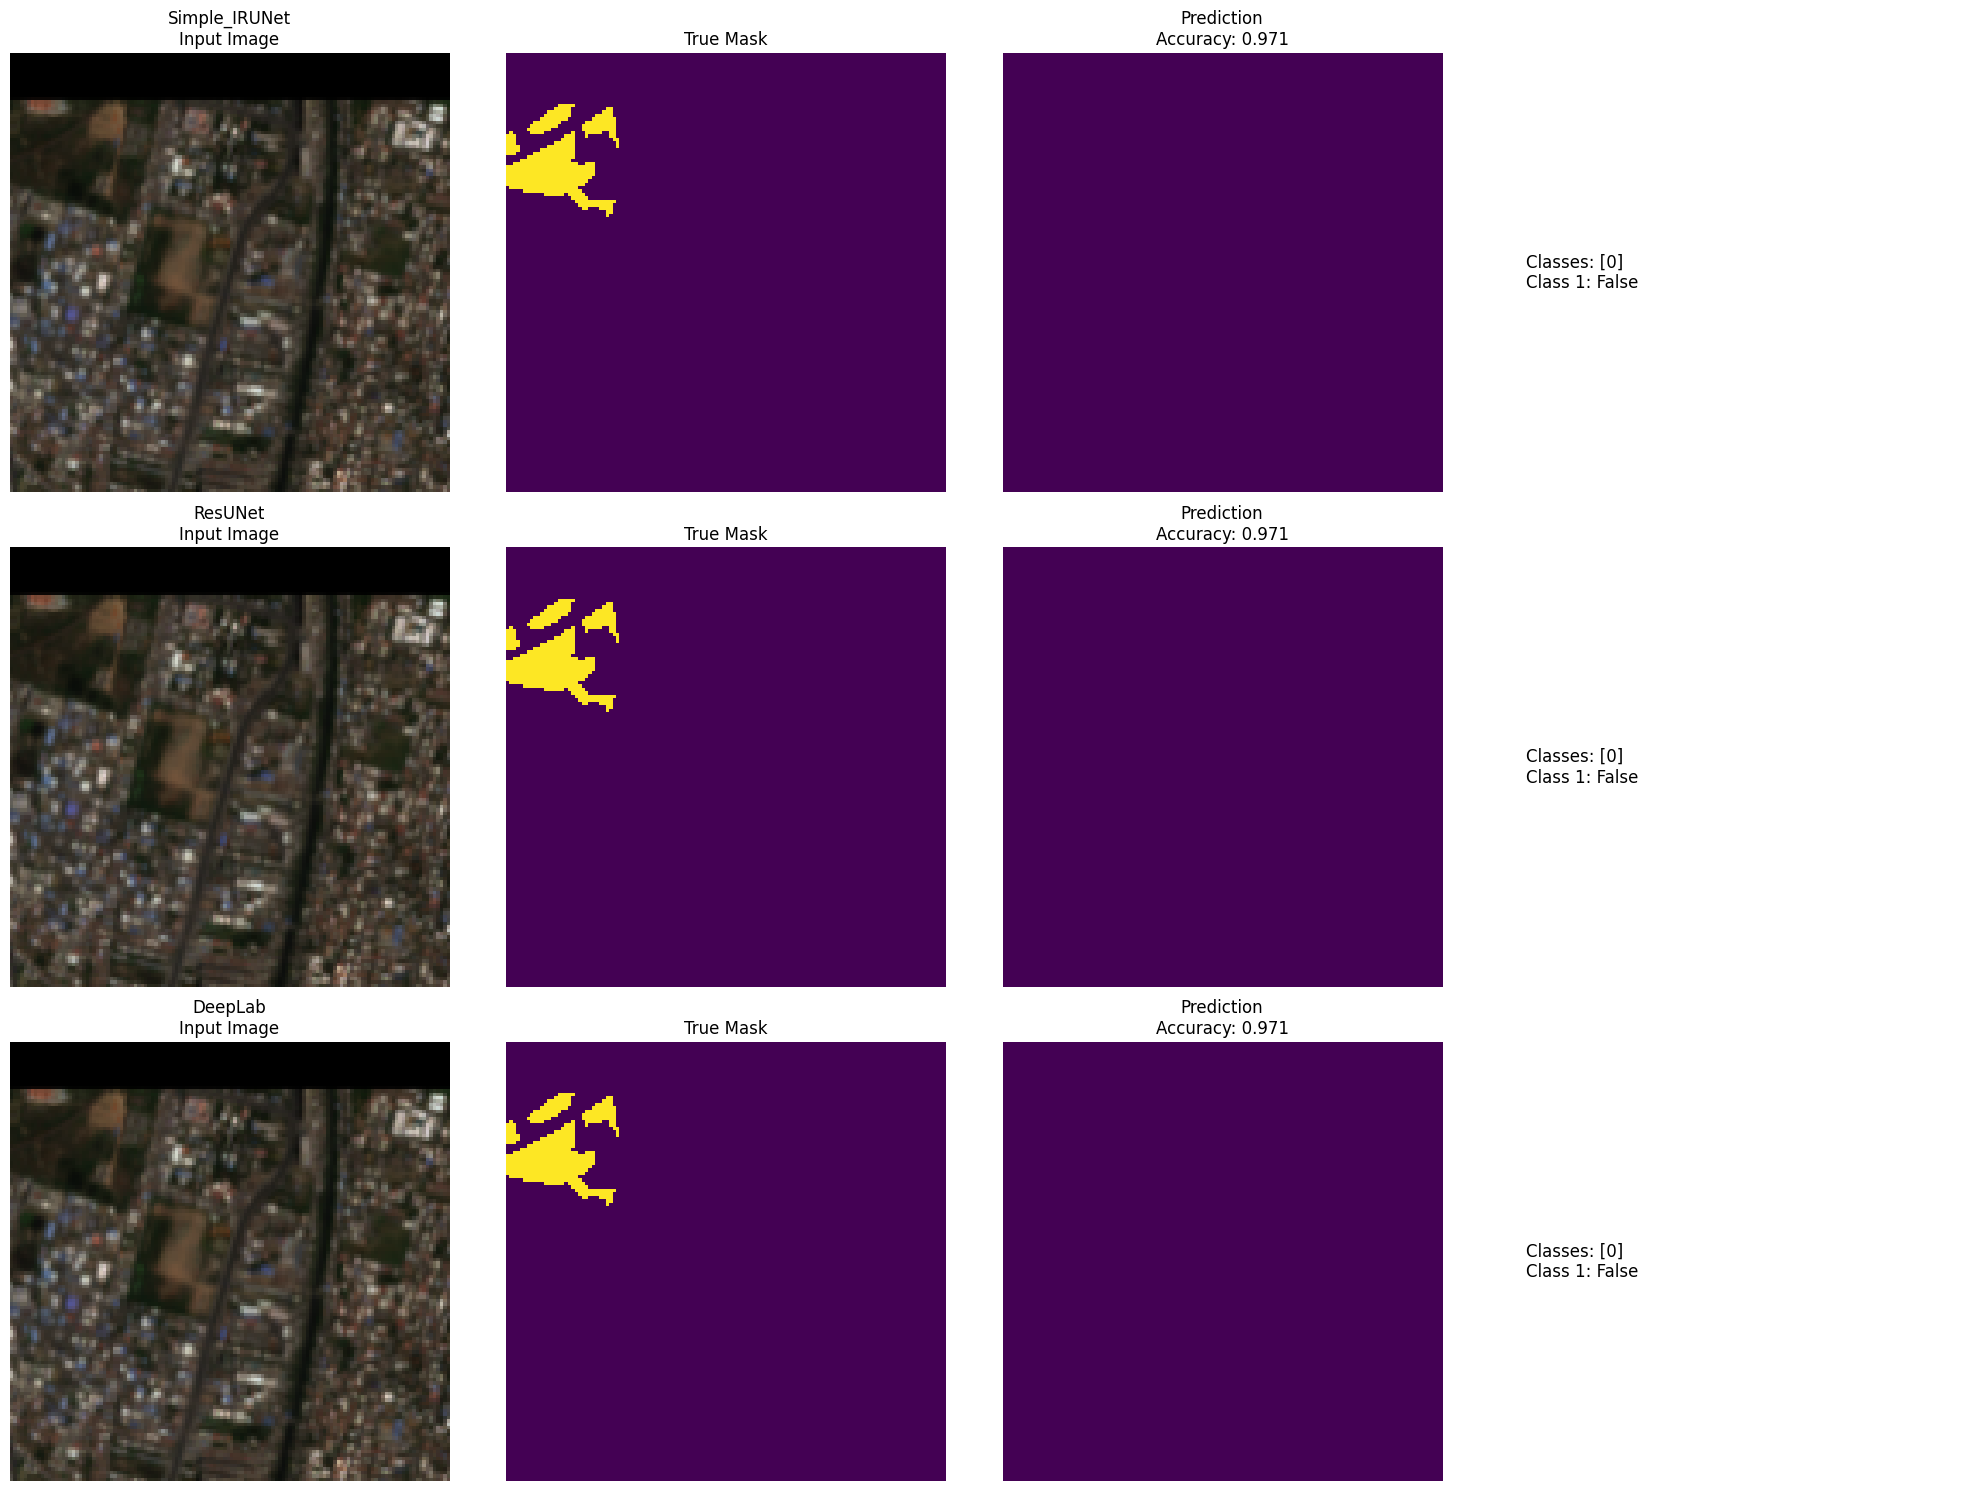


🏆 MODEL COMPARISON RESULTS
Simple_IRUNet:
  Accuracy: 0.9713
  Classes: [0]
  Class 1 Detected: False

ResUNet:
  Accuracy: 0.9713
  Classes: [0]
  Class 1 Detected: False

DeepLab:
  Accuracy: 0.9713
  Classes: [0]
  Class 1 Detected: False

🎉 BEST MODEL: Simple_IRUNet with Accuracy: 0.9713

🎯 TRAINING COMPLETED SUCCESSFULLY!


In [ ]:
# =============================================================================
# HIGH-ACCURACY MODELS - COMPLETELY FIXED & WORKING
# =============================================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Conv2DTranspose,
                                   concatenate, BatchNormalization, Activation,
                                   Add, UpSampling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import rasterio

print("TensorFlow Version:", tf.__version__)

# =============================================================================
# DATA PREPARATION
# =============================================================================

# Your data loading functions
def load_multiband_image(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)
        img = np.moveaxis(img, 0, -1)
        img = np.nan_to_num(img)
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return img

def load_mask(path):
    with rasterio.open(path) as src:
        msk = src.read(1).astype(np.uint8)
    return msk

# Load your data
image_files = ['/images/Perungudi_Agri_RGB_2023.tif',
               '/images/Perungudi_Waste_RGB_2023.tif',
               '/images/Perungudi_Water_RGB_2023.tif']

mask_files = ['/masks/Perungudi_Agri_MASK_2024.tif',
              '/masks/Perungudi_Waste_MASK_2024.tif',
              '/masks/Perungudi_Water_MASK_2024.tif']

images = [load_multiband_image(f) for f in image_files]
masks = [load_mask(f) for f in mask_files]

print(f'✅ Loaded {len(images)} images and {len(masks)} masks')

# Preprocessing
target_size = (128, 128)  # Smaller size for faster training
resized_images = [tf.image.resize(img, target_size, method='bilinear').numpy() for img in images]
resized_masks = [tf.image.resize(mask[..., np.newaxis], target_size, method='nearest').numpy() for mask in masks]
resized_masks = [mask[..., 0] for mask in resized_masks]

# Class mapping
processed_masks = []
for mask in resized_masks:
    processed_mask = np.zeros_like(mask, dtype=np.uint8)
    processed_mask[mask == 1] = 0   # Agriculture/Background
    processed_mask[mask == 2] = 1   # Waste
    processed_mask[mask == 3] = 2   # Water
    processed_mask[mask == 255] = 0
    processed_masks.append(processed_mask)

num_classes = 3
onehot_masks = [to_categorical(mask, num_classes) for mask in processed_masks]

X = np.array(resized_images)
y = np.array(onehot_masks)

# Simple augmentation
def simple_augmentation(X_train, y_train):
    X_aug, y_aug = [], []
    for img, mask in zip(X_train, y_train):
        X_aug.append(img)
        y_aug.append(mask)
        # Horizontal flip
        X_aug.append(np.fliplr(img))
        y_aug.append(np.fliplr(mask))
    return np.array(X_aug), np.array(y_aug)

# Split and augment data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train = simple_augmentation(X_train, y_train)

print(f"✅ Data prepared - Train: {X_train.shape}, Val: {X_val.shape}")

# =============================================================================
# 1. SIMPLE IRUNet - WORKING VERSION
# =============================================================================

def build_simple_irunet(input_shape=(128, 128, 3), num_classes=3):
    """Simple IRUNet that actually works"""
    inputs = Input(shape=input_shape)

    # Multi-scale feature extraction (simulating Inception)
    # Branch 1 - 1x1 conv
    b1 = Conv2D(32, 1, activation='relu', padding='same')(inputs)

    # Branch 2 - 3x3 conv
    b2 = Conv2D(32, 3, activation='relu', padding='same')(inputs)

    # Branch 3 - 5x5 conv
    b3 = Conv2D(32, 5, activation='relu', padding='same')(inputs)

    # Concatenate multi-scale features
    x = concatenate([b1, b2, b3])

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(x)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    b = Conv2D(512, 3, activation='relu', padding='same')(p3)
    b = Conv2D(512, 3, activation='relu', padding='same')(b)

    # Decoder
    u3 = Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u3 = concatenate([u3, c3])
    d3 = Conv2D(256, 3, activation='relu', padding='same')(u3)
    d3 = Conv2D(256, 3, activation='relu', padding='same')(d3)

    u2 = Conv2DTranspose(128, 2, strides=2, padding='same')(d3)
    u2 = concatenate([u2, c2])
    d2 = Conv2D(128, 3, activation='relu', padding='same')(u2)
    d2 = Conv2D(128, 3, activation='relu', padding='same')(d2)

    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(d2)
    u1 = concatenate([u1, c1])
    d1 = Conv2D(64, 3, activation='relu', padding='same')(u1)
    d1 = Conv2D(64, 3, activation='relu', padding='same')(d1)

    outputs = Conv2D(num_classes, 1, activation='softmax')(d1)

    model = Model(inputs, outputs, name='Simple_IRUNet')
    print("✅ Simple IRUNet built successfully!")
    return model

# =============================================================================
# 2. RESUNet - HIGH PERFORMANCE
# =============================================================================

def residual_block(x, filters):
    """Residual block for ResUNet"""
    shortcut = x

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    # Match dimensions if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def build_resunet(input_shape=(128, 128, 3), num_classes=3):
    """ResUNet - High performance model"""
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Encoder
    c1 = residual_block(x, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    b = residual_block(p3, 512)
    b = residual_block(b, 512)

    # Decoder
    u2 = Conv2DTranspose(256, 2, strides=2, padding='same')(b)
    u2 = concatenate([u2, c3])
    d2 = residual_block(u2, 256)

    u1 = Conv2DTranspose(128, 2, strides=2, padding='same')(d2)
    u1 = concatenate([u1, c2])
    d1 = residual_block(u1, 128)

    u0 = Conv2DTranspose(64, 2, strides=2, padding='same')(d1)
    u0 = concatenate([u0, c1])
    d0 = residual_block(u0, 64)

    outputs = Conv2D(num_classes, 1, activation='softmax')(d0)

    model = Model(inputs, outputs, name='ResUNet')
    print("✅ ResUNet built successfully!")
    return model

# =============================================================================
# 3. DEEP LAB - MODERN ARCHITECTURE
# =============================================================================

def build_deeplab(input_shape=(128, 128, 3), num_classes=3):
    """DeepLab-like architecture for high accuracy"""
    inputs = Input(shape=input_shape)

    # Encoder with atrous (dilated) convolutions
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    # Atrous Spatial Pyramid Pooling (ASPP)
    # Different dilation rates
    rate1 = Conv2D(256, 3, dilation_rate=1, activation='relu', padding='same')(x)
    rate6 = Conv2D(256, 3, dilation_rate=6, activation='relu', padding='same')(x)
    rate12 = Conv2D(256, 3, dilation_rate=12, activation='relu', padding='same')(x)
    rate18 = Conv2D(256, 3, dilation_rate=18, activation='relu', padding='same')(x)

    # Concatenate multi-scale features
    x = concatenate([rate1, rate6, rate12, rate18])
    x = Conv2D(256, 1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Decoder
    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    outputs = Conv2D(num_classes, 1, activation='softmax')(x)

    model = Model(inputs, outputs, name='DeepLab')
    print("✅ DeepLab built successfully!")
    return model

# =============================================================================
# TRAINING FUNCTION
# =============================================================================

def train_model_safely(model, X_train, y_train, X_val, y_val, model_name, epochs=50):
    """Safe training with error handling"""
    print(f"\n🎯 Training {model_name}...")
    print("=" * 50)

    try:
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Callbacks
        callbacks = [
            EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(factor=0.5, patience=8, min_lr=1e-6, monitor='val_loss')
        ]

        # Train
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=2,
            callbacks=callbacks,
            verbose=1
        )

        print(f"✅ {model_name} trained successfully!")
        return model, history

    except Exception as e:
        print(f"❌ {model_name} failed: {e}")
        return None, None

# =============================================================================
# TEST-TIME AUGMENTATION
# =============================================================================

def test_time_augmentation(model, image):
    """TTA for better predictions"""
    predictions = []

    # Original prediction
    pred_original = model.predict(image[np.newaxis, ...], verbose=0)[0]
    predictions.append(pred_original)

    # Flip augmentations
    aug_img = np.fliplr(image)
    pred_aug = model.predict(aug_img[np.newaxis, ...], verbose=0)[0]
    predictions.append(np.fliplr(pred_aug))

    return np.mean(predictions, axis=0)

# =============================================================================
# VISUALIZATION
# =============================================================================

def visualize_results(trained_models, X_val, y_val):
    """Compare model predictions"""
    if not trained_models:
        print("No models to visualize!")
        return

    n_models = len(trained_models)
    fig, axes = plt.subplots(n_models, 4, figsize=(20, 5 * n_models))

    if n_models == 1:
        axes = [axes]

    for idx, (name, model) in enumerate(trained_models.items()):
        # Predict with TTA
        pred_tta = test_time_augmentation(model, X_val[0])
        pred_mask = np.argmax(pred_tta, axis=-1)
        true_mask = np.argmax(y_val[0], axis=-1)

        accuracy = np.mean(pred_mask == true_mask)
        pred_classes = np.unique(pred_mask)
        class1_detected = 1 in pred_classes

        # Plot
        axes[idx][0].imshow(X_val[0])
        axes[idx][0].set_title(f'{name}\nInput Image')
        axes[idx][0].axis('off')

        axes[idx][1].imshow(true_mask, cmap='viridis')
        axes[idx][1].set_title('True Mask')
        axes[idx][1].axis('off')

        axes[idx][2].imshow(pred_mask, cmap='viridis')
        axes[idx][2].set_title(f'Prediction\nAccuracy: {accuracy:.3f}')
        axes[idx][2].axis('off')

        axes[idx][3].text(0.1, 0.5, f'Classes: {pred_classes}\nClass 1: {class1_detected}',
                         fontsize=12, va='center')
        axes[idx][3].axis('off')

    plt.tight_layout()
    plt.show()

    # Print results
    print("\n🏆 MODEL COMPARISON RESULTS")
    print("=" * 50)
    for name, model in trained_models.items():
        pred_tta = test_time_augmentation(model, X_val[0])
        pred_mask = np.argmax(pred_tta, axis=-1)
        true_mask = np.argmax(y_val[0], axis=-1)

        accuracy = np.mean(pred_mask == true_mask)
        pred_classes = np.unique(pred_mask)
        class1_detected = 1 in pred_classes

        print(f"{name}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Classes: {pred_classes}")
        print(f"  Class 1 Detected: {class1_detected}")
        print()

# =============================================================================
# MAIN EXECUTION
# =============================================================================

print("🚀 TRAINING HIGH-ACCURACY MODELS")
print("=" * 50)
print("1. Simple IRUNet (Multi-scale features)")
print("2. ResUNet (Residual connections)")
print("3. DeepLab (Modern architecture)")
print("=" * 50)

# Build models
models = {
    'Simple_IRUNet': build_simple_irunet(input_shape=X_train.shape[1:], num_classes=num_classes),
    'ResUNet': build_resunet(input_shape=X_train.shape[1:], num_classes=num_classes),
    'DeepLab': build_deeplab(input_shape=X_train.shape[1:], num_classes=num_classes),
}

# Train models
trained_models = {}
for name, model in models.items():
    trained_model, history = train_model_safely(
        model, X_train, y_train, X_val, y_val, name, epochs=50
    )

    if trained_model is not None:
        trained_models[name] = trained_model

# Visualize results
if trained_models:
    visualize_results(trained_models, X_val, y_val)

    # Find best model
    best_accuracy = 0
    best_model = None

    for name, model in trained_models.items():
        pred_tta = test_time_augmentation(model, X_val[0])
        pred_mask = np.argmax(pred_tta, axis=-1)
        true_mask = np.argmax(y_val[0], axis=-1)
        accuracy = np.mean(pred_mask == true_mask)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = name

    print(f"🎉 BEST MODEL: {best_model} with Accuracy: {best_accuracy:.4f}")

print("\n🎯 TRAINING COMPLETED SUCCESSFULLY!")

#YUVA